In [1]:
import datetime
import time
import math
import pandas as pd
import numpy as np
import scipy.stats as stat
from numpy import std, mean
#import statsmodels.api as sm
import statsmodels.stats as sm_stats
from statsmodels.stats.proportion import proportions_ztest
import ast
import re, string, unicodedata
import copy
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import train_test_split
from sklearn.base import RegressorMixin, BaseEstimator, ClassifierMixin
from sklearn.metrics import average_precision_score
from catboost import CatBoostClassifier, CatBoostRegressor, to_classifier, EFstrType
import shap
shap.initjs() 

/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
"is" with a literal. Did you mean "=="?
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql import Window
from pyspark.sql import functions as f 
from pyspark.sql.functions import row_number
from pyspark.sql import types
from pyspark.sql.types import *
from pyspark import SparkConf
from pyspark.sql.functions import udf
from pyspark.sql.functions import col, countDistinct,concat, isnan, when, count
import os
import subprocess

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [3]:
#Create the connection to hadoop cluster
appname='abc'
spark = (SparkSession.builder.appName(appname)
.enableHiveSupport().getOrCreate())

### Assign Variables

In [4]:
#Cohort and related dates
MMYYYY = '072022'
cohort = '2022-07-31'

### Load data and convert Spark DF to Pandas DF

In [ ]:
#Pull data into spark DF and convert to pandas DF
data = spark.sql("""
select * from 
""".format(MMYYYY=MMYYYY))

decimal_cols = [ f[0] for f in data.dtypes if f[1].startswith('decimal') ]
data = data.select(
    [col(name).cast('double') if name in decimal_cols else col(name) for name, colType in data.dtypes]
)

data.createOrReplaceTempView("data")

df = data.toPandas()


In [ ]:
#list of useful features, with some removed (i.e. constant features), and a list of features with collinear features removed
features_list = [
    ''
    ,''
]

collinear_features_to_remove = [
    ''
    ,''
]

features_list_decollinear = [feature for feature in features_list if feature not in collinear_features_to_remove]

## Propensity Modeling

In [ ]:
# cat_features = [
#     j for j, name in 
#     enumerate(df[features_list]) if not pd.api.types.is_numeric_dtype(df[name])
# ]

cat_features = [
    j for j, name in 
    enumerate(df[features_list_decollinear]) if not pd.api.types.is_numeric_dtype(df[name])
]

In [ ]:
# #create a combined feature for both treatment and conversion target to stratify on
# def create_stratify_var(row):
#     if row['treatment_status'] == 1 & row['attrited_pt_flag'] == 1:
#         return 1
#     elif row['treatment_status'] == 1 & row['attrited_pt_flag'] == 0:
#         return 2
#     elif row['treatment_status'] == 0 & row['attrited_pt_flag'] == 1:
#         return 3 
#     else:
#         #row['treatment'] == 1 & row['conversion_target'] == 0
#         return 4

# df['stratify_var'] = df.apply(create_stratify_var, axis=1)

In [10]:
#Using cross validation, extract models for averaged prediction
from catboost import Pool, cv

# x, t, idx = df[features_list], df['treatment_status'], df.index
x, t, idx = df[features_list_decollinear], df['treatment_status'], df.index

cv_pool = Pool(data=x,
                  label=t,
                  cat_features=cat_features)

#Use PRAUC as metric due to high imbalance of the data (~2.4% positive class)
params = {"iterations": 1000,
          "depth": 3,
          "loss_function": "Logloss",
          "verbose": True,
          "early_stopping_rounds": 25,
          "random_state": 2023,
          "eval_metric": "PRAUC"}

scores = cv(cv_pool,
            params,
            fold_count=3, 
            plot="True",
            as_pandas=True,
            stratified=True,
            return_models=True)

#From CV results we see that models converge with a PRAUC average of ~0.45, which is significantly better than the positive class
#prevalence of ~0.02


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	learn: 0.4094519	test: 0.4064341	best: 0.4064341 (0)	total: 290ms	remaining: 4m 50s
1:	learn: 0.4103128	test: 0.4054458	best: 0.4064341 (0)	total: 528ms	remaining: 4m 23s
2:	learn: 0.3886289	test: 0.3835227	best: 0.4064341 (0)	total: 766ms	remaining: 4m 14s
3:	learn: 0.4052043	test: 0.3995903	best: 0.4064341 (0)	total: 1.03s	remaining: 4m 16s
4:	learn: 0.4170340	test: 0.4114611	best: 0.4114611 (4)	total: 1.28s	remaining: 4m 15s
5:	learn: 0.4198367	test: 0.4148545	best: 0.4148545 (5)	total: 1.53s	remaining: 4m 13s
6:	learn: 0.4175512	test: 0.4124096	best: 0.4148545 (5)	total: 1.78s	remaining: 4m 11s
7:	learn: 0.4194267	test: 0.4146723	best: 0.4148545 (5)	total: 2.03s	remaining: 4m 11s
8:	learn: 0.4201941	test: 0.4154000	best: 0.4154000 (8)	total: 2.29s	remaining: 4m 12s
9:	learn: 0.4209475	test: 0.4164327	best: 0.4164327 (9)	total: 2.53s	remaining: 4m 10s
10:	learn: 0.4240908	test: 0.4187532	best: 0.4187532 (10)	total: 2.77s	remaining: 4m 8s
11:	learn: 0.424640

93:	learn: 0.4478562	test: 0.4435618	best: 0.4435618 (93)	total: 26.3s	remaining: 4m 13s
94:	learn: 0.4479320	test: 0.4436182	best: 0.4436182 (94)	total: 26.6s	remaining: 4m 13s
95:	learn: 0.4479869	test: 0.4436472	best: 0.4436472 (95)	total: 26.9s	remaining: 4m 13s
96:	learn: 0.4480931	test: 0.4437417	best: 0.4437417 (96)	total: 27.2s	remaining: 4m 12s
97:	learn: 0.4481843	test: 0.4438209	best: 0.4438209 (97)	total: 27.5s	remaining: 4m 12s
98:	learn: 0.4482656	test: 0.4439047	best: 0.4439047 (98)	total: 27.8s	remaining: 4m 12s
99:	learn: 0.4483831	test: 0.4440167	best: 0.4440167 (99)	total: 28.1s	remaining: 4m 13s
100:	learn: 0.4484764	test: 0.4441444	best: 0.4441444 (100)	total: 28.4s	remaining: 4m 13s
101:	learn: 0.4485533	test: 0.4442113	best: 0.4442113 (101)	total: 28.8s	remaining: 4m 13s
102:	learn: 0.4486751	test: 0.4443517	best: 0.4443517 (102)	total: 29.1s	remaining: 4m 13s
103:	learn: 0.4487080	test: 0.4443939	best: 0.4443939 (103)	total: 29.4s	remaining: 4m 13s
104:	learn: 0

185:	learn: 0.4536250	test: 0.4485203	best: 0.4485203 (185)	total: 54.6s	remaining: 3m 59s
186:	learn: 0.4536578	test: 0.4485355	best: 0.4485355 (186)	total: 54.9s	remaining: 3m 58s
187:	learn: 0.4537381	test: 0.4486182	best: 0.4486182 (187)	total: 55.2s	remaining: 3m 58s
188:	learn: 0.4537938	test: 0.4486686	best: 0.4486686 (188)	total: 55.5s	remaining: 3m 58s
189:	learn: 0.4538277	test: 0.4486897	best: 0.4486897 (189)	total: 55.8s	remaining: 3m 57s
190:	learn: 0.4538477	test: 0.4486908	best: 0.4486908 (190)	total: 56.1s	remaining: 3m 57s
191:	learn: 0.4539121	test: 0.4487524	best: 0.4487524 (191)	total: 56.4s	remaining: 3m 57s
192:	learn: 0.4539429	test: 0.4487809	best: 0.4487809 (192)	total: 56.7s	remaining: 3m 57s
193:	learn: 0.4539643	test: 0.4487928	best: 0.4487928 (193)	total: 57s	remaining: 3m 56s
194:	learn: 0.4540953	test: 0.4489009	best: 0.4489009 (194)	total: 57.3s	remaining: 3m 56s
195:	learn: 0.4541528	test: 0.4489495	best: 0.4489495 (195)	total: 57.6s	remaining: 3m 56s
1

275:	learn: 0.4576026	test: 0.4516375	best: 0.4516375 (275)	total: 1m 22s	remaining: 3m 37s
276:	learn: 0.4576322	test: 0.4516388	best: 0.4516388 (276)	total: 1m 23s	remaining: 3m 37s
277:	learn: 0.4577120	test: 0.4516866	best: 0.4516866 (277)	total: 1m 23s	remaining: 3m 37s
278:	learn: 0.4577252	test: 0.4516958	best: 0.4516958 (278)	total: 1m 23s	remaining: 3m 36s
279:	learn: 0.4577566	test: 0.4517249	best: 0.4517249 (279)	total: 1m 24s	remaining: 3m 36s
280:	learn: 0.4578011	test: 0.4517844	best: 0.4517844 (280)	total: 1m 24s	remaining: 3m 36s
281:	learn: 0.4578210	test: 0.4518038	best: 0.4518038 (281)	total: 1m 24s	remaining: 3m 35s
282:	learn: 0.4578651	test: 0.4518383	best: 0.4518383 (282)	total: 1m 25s	remaining: 3m 35s
283:	learn: 0.4578846	test: 0.4518379	best: 0.4518383 (282)	total: 1m 25s	remaining: 3m 35s
284:	learn: 0.4579192	test: 0.4518683	best: 0.4518683 (284)	total: 1m 25s	remaining: 3m 34s
285:	learn: 0.4579474	test: 0.4518913	best: 0.4518913 (285)	total: 1m 25s	remain

365:	learn: 0.4601469	test: 0.4533212	best: 0.4533212 (365)	total: 1m 50s	remaining: 3m 11s
366:	learn: 0.4601649	test: 0.4533385	best: 0.4533385 (366)	total: 1m 51s	remaining: 3m 11s
367:	learn: 0.4601805	test: 0.4533503	best: 0.4533503 (367)	total: 1m 51s	remaining: 3m 11s
368:	learn: 0.4601947	test: 0.4533552	best: 0.4533552 (368)	total: 1m 51s	remaining: 3m 10s
369:	learn: 0.4602287	test: 0.4533690	best: 0.4533690 (369)	total: 1m 51s	remaining: 3m 10s
370:	learn: 0.4602699	test: 0.4534057	best: 0.4534057 (370)	total: 1m 52s	remaining: 3m 10s
371:	learn: 0.4602907	test: 0.4534187	best: 0.4534187 (371)	total: 1m 52s	remaining: 3m 10s
372:	learn: 0.4602976	test: 0.4534116	best: 0.4534187 (371)	total: 1m 52s	remaining: 3m 9s
373:	learn: 0.4603193	test: 0.4534346	best: 0.4534346 (373)	total: 1m 53s	remaining: 3m 9s
374:	learn: 0.4603365	test: 0.4534415	best: 0.4534415 (374)	total: 1m 53s	remaining: 3m 9s
375:	learn: 0.4603497	test: 0.4534551	best: 0.4534551 (375)	total: 1m 53s	remaining

455:	learn: 0.4621631	test: 0.4543307	best: 0.4543307 (455)	total: 2m 18s	remaining: 2m 45s
456:	learn: 0.4621809	test: 0.4543567	best: 0.4543567 (456)	total: 2m 18s	remaining: 2m 45s
457:	learn: 0.4621976	test: 0.4543574	best: 0.4543574 (457)	total: 2m 19s	remaining: 2m 44s
458:	learn: 0.4622496	test: 0.4543723	best: 0.4543723 (458)	total: 2m 19s	remaining: 2m 44s
459:	learn: 0.4622644	test: 0.4543527	best: 0.4543723 (458)	total: 2m 19s	remaining: 2m 44s
460:	learn: 0.4622934	test: 0.4543884	best: 0.4543884 (460)	total: 2m 20s	remaining: 2m 43s
461:	learn: 0.4623115	test: 0.4543851	best: 0.4543884 (460)	total: 2m 20s	remaining: 2m 43s
462:	learn: 0.4623292	test: 0.4543992	best: 0.4543992 (462)	total: 2m 20s	remaining: 2m 43s
463:	learn: 0.4623434	test: 0.4544023	best: 0.4544023 (463)	total: 2m 21s	remaining: 2m 42s
464:	learn: 0.4623555	test: 0.4543887	best: 0.4544023 (463)	total: 2m 21s	remaining: 2m 42s
465:	learn: 0.4623756	test: 0.4544196	best: 0.4544196 (465)	total: 2m 21s	remain

545:	learn: 0.4640117	test: 0.4550334	best: 0.4550334 (545)	total: 2m 46s	remaining: 2m 18s
546:	learn: 0.4640346	test: 0.4550469	best: 0.4550469 (546)	total: 2m 46s	remaining: 2m 18s
547:	learn: 0.4640532	test: 0.4550470	best: 0.4550470 (547)	total: 2m 47s	remaining: 2m 17s
548:	learn: 0.4640755	test: 0.4550526	best: 0.4550526 (548)	total: 2m 47s	remaining: 2m 17s
549:	learn: 0.4640865	test: 0.4550649	best: 0.4550649 (549)	total: 2m 47s	remaining: 2m 17s
550:	learn: 0.4641053	test: 0.4550714	best: 0.4550714 (550)	total: 2m 47s	remaining: 2m 16s
551:	learn: 0.4641228	test: 0.4550950	best: 0.4550950 (551)	total: 2m 48s	remaining: 2m 16s
552:	learn: 0.4641415	test: 0.4550988	best: 0.4550988 (552)	total: 2m 48s	remaining: 2m 16s
553:	learn: 0.4641485	test: 0.4551019	best: 0.4551019 (553)	total: 2m 48s	remaining: 2m 15s
554:	learn: 0.4641894	test: 0.4551103	best: 0.4551103 (554)	total: 2m 49s	remaining: 2m 15s
555:	learn: 0.4641991	test: 0.4551184	best: 0.4551184 (555)	total: 2m 49s	remain

636:	learn: 0.4655881	test: 0.4555730	best: 0.4555753 (635)	total: 3m 13s	remaining: 1m 50s
637:	learn: 0.4656029	test: 0.4555681	best: 0.4555753 (635)	total: 3m 13s	remaining: 1m 50s
638:	learn: 0.4656204	test: 0.4555784	best: 0.4555784 (638)	total: 3m 14s	remaining: 1m 49s
639:	learn: 0.4656350	test: 0.4555870	best: 0.4555870 (639)	total: 3m 14s	remaining: 1m 49s
640:	learn: 0.4656438	test: 0.4555926	best: 0.4555926 (640)	total: 3m 14s	remaining: 1m 49s
641:	learn: 0.4656614	test: 0.4555954	best: 0.4555954 (641)	total: 3m 14s	remaining: 1m 48s
642:	learn: 0.4656705	test: 0.4555802	best: 0.4555954 (641)	total: 3m 15s	remaining: 1m 48s
643:	learn: 0.4656932	test: 0.4555946	best: 0.4555954 (641)	total: 3m 15s	remaining: 1m 48s
644:	learn: 0.4657037	test: 0.4555962	best: 0.4555962 (644)	total: 3m 15s	remaining: 1m 47s
645:	learn: 0.4657222	test: 0.4555987	best: 0.4555987 (645)	total: 3m 16s	remaining: 1m 47s
646:	learn: 0.4657344	test: 0.4556089	best: 0.4556089 (646)	total: 3m 16s	remain

726:	learn: 0.4668907	test: 0.4559812	best: 0.4559812 (726)	total: 3m 41s	remaining: 1m 23s
727:	learn: 0.4669213	test: 0.4559689	best: 0.4559812 (726)	total: 3m 41s	remaining: 1m 22s
728:	learn: 0.4669421	test: 0.4559819	best: 0.4559819 (728)	total: 3m 42s	remaining: 1m 22s
729:	learn: 0.4669539	test: 0.4559792	best: 0.4559819 (728)	total: 3m 42s	remaining: 1m 22s
730:	learn: 0.4669606	test: 0.4559828	best: 0.4559828 (730)	total: 3m 42s	remaining: 1m 22s
731:	learn: 0.4669790	test: 0.4559923	best: 0.4559923 (731)	total: 3m 43s	remaining: 1m 21s
732:	learn: 0.4670031	test: 0.4560030	best: 0.4560030 (732)	total: 3m 43s	remaining: 1m 21s
733:	learn: 0.4670195	test: 0.4560128	best: 0.4560128 (733)	total: 3m 44s	remaining: 1m 21s
734:	learn: 0.4670292	test: 0.4560031	best: 0.4560128 (733)	total: 3m 45s	remaining: 1m 21s
735:	learn: 0.4670392	test: 0.4560038	best: 0.4560128 (733)	total: 3m 45s	remaining: 1m 20s
736:	learn: 0.4670511	test: 0.4560104	best: 0.4560128 (733)	total: 3m 46s	remain

816:	learn: 0.4678796	test: 0.4563229	best: 0.4563229 (816)	total: 4m 34s	remaining: 1m 1s
817:	learn: 0.4678922	test: 0.4563232	best: 0.4563232 (817)	total: 4m 35s	remaining: 1m 1s
818:	learn: 0.4678991	test: 0.4563226	best: 0.4563232 (817)	total: 4m 35s	remaining: 1m
819:	learn: 0.4679245	test: 0.4563380	best: 0.4563380 (819)	total: 4m 36s	remaining: 1m
820:	learn: 0.4679406	test: 0.4563518	best: 0.4563518 (820)	total: 4m 37s	remaining: 1m
821:	learn: 0.4679589	test: 0.4563682	best: 0.4563682 (821)	total: 4m 37s	remaining: 1m
822:	learn: 0.4679775	test: 0.4563668	best: 0.4563682 (821)	total: 4m 38s	remaining: 59.9s
823:	learn: 0.4679913	test: 0.4563674	best: 0.4563682 (821)	total: 4m 39s	remaining: 59.6s
824:	learn: 0.4679991	test: 0.4563579	best: 0.4563682 (821)	total: 4m 39s	remaining: 59.3s
825:	learn: 0.4680145	test: 0.4563696	best: 0.4563696 (825)	total: 4m 40s	remaining: 59.1s
826:	learn: 0.4680200	test: 0.4563765	best: 0.4563765 (826)	total: 4m 40s	remaining: 58.8s
827:	learn:

907:	learn: 0.4690339	test: 0.4566636	best: 0.4566636 (907)	total: 5m 14s	remaining: 31.9s
908:	learn: 0.4690400	test: 0.4566580	best: 0.4566636 (907)	total: 5m 15s	remaining: 31.5s
909:	learn: 0.4690596	test: 0.4566227	best: 0.4566636 (907)	total: 5m 15s	remaining: 31.2s
910:	learn: 0.4690723	test: 0.4566274	best: 0.4566636 (907)	total: 5m 15s	remaining: 30.9s
911:	learn: 0.4690865	test: 0.4566219	best: 0.4566636 (907)	total: 5m 16s	remaining: 30.5s
912:	learn: 0.4691067	test: 0.4566314	best: 0.4566636 (907)	total: 5m 16s	remaining: 30.2s
913:	learn: 0.4691198	test: 0.4566399	best: 0.4566636 (907)	total: 5m 16s	remaining: 29.8s
914:	learn: 0.4691378	test: 0.4566414	best: 0.4566636 (907)	total: 5m 17s	remaining: 29.5s
915:	learn: 0.4691433	test: 0.4566329	best: 0.4566636 (907)	total: 5m 17s	remaining: 29.1s
916:	learn: 0.4691539	test: 0.4566385	best: 0.4566636 (907)	total: 5m 18s	remaining: 28.8s
917:	learn: 0.4691594	test: 0.4566402	best: 0.4566636 (907)	total: 5m 18s	remaining: 28.4s

998:	learn: 0.4701549	test: 0.4568072	best: 0.4568126 (994)	total: 5m 47s	remaining: 348ms
999:	learn: 0.4701601	test: 0.4568042	best: 0.4568126 (994)	total: 5m 48s	remaining: 0us

bestTest = 0.4568125773
bestIteration = 994

Training on fold [1/3]
0:	learn: 0.4086890	test: 0.4081408	best: 0.4081408 (0)	total: 283ms	remaining: 4m 42s
1:	learn: 0.3815640	test: 0.3824862	best: 0.4081408 (0)	total: 573ms	remaining: 4m 45s
2:	learn: 0.3947501	test: 0.3948706	best: 0.4081408 (0)	total: 794ms	remaining: 4m 23s
3:	learn: 0.4017097	test: 0.4021590	best: 0.4081408 (0)	total: 1.04s	remaining: 4m 18s
4:	learn: 0.4025824	test: 0.4033651	best: 0.4081408 (0)	total: 1.26s	remaining: 4m 11s
5:	learn: 0.4075802	test: 0.4075130	best: 0.4081408 (0)	total: 1.49s	remaining: 4m 6s
6:	learn: 0.4059266	test: 0.4056308	best: 0.4081408 (0)	total: 1.72s	remaining: 4m 3s
7:	learn: 0.4096820	test: 0.4081307	best: 0.4081408 (0)	total: 1.97s	remaining: 4m 3s
8:	learn: 0.4096722	test: 0.4081526	best: 0.4081526 (8)	to

91:	learn: 0.4460360	test: 0.4460993	best: 0.4460993 (91)	total: 23.9s	remaining: 3m 55s
92:	learn: 0.4461966	test: 0.4462306	best: 0.4462306 (92)	total: 24.1s	remaining: 3m 55s
93:	learn: 0.4462784	test: 0.4462617	best: 0.4462617 (93)	total: 24.4s	remaining: 3m 55s
94:	learn: 0.4463859	test: 0.4463342	best: 0.4463342 (94)	total: 24.6s	remaining: 3m 54s
95:	learn: 0.4464798	test: 0.4464259	best: 0.4464259 (95)	total: 24.9s	remaining: 3m 54s
96:	learn: 0.4465781	test: 0.4465109	best: 0.4465109 (96)	total: 25.2s	remaining: 3m 54s
97:	learn: 0.4468024	test: 0.4467751	best: 0.4467751 (97)	total: 25.4s	remaining: 3m 54s
98:	learn: 0.4468674	test: 0.4468508	best: 0.4468508 (98)	total: 25.7s	remaining: 3m 53s
99:	learn: 0.4468874	test: 0.4468607	best: 0.4468607 (99)	total: 26s	remaining: 3m 53s
100:	learn: 0.4469736	test: 0.4469638	best: 0.4469638 (100)	total: 26.2s	remaining: 3m 53s
101:	learn: 0.4470380	test: 0.4470195	best: 0.4470195 (101)	total: 26.5s	remaining: 3m 53s
102:	learn: 0.44715

182:	learn: 0.4518233	test: 0.4512771	best: 0.4512771 (182)	total: 50.3s	remaining: 3m 44s
183:	learn: 0.4518592	test: 0.4513110	best: 0.4513110 (183)	total: 50.6s	remaining: 3m 44s
184:	learn: 0.4518739	test: 0.4513181	best: 0.4513181 (184)	total: 50.9s	remaining: 3m 44s
185:	learn: 0.4518854	test: 0.4513265	best: 0.4513265 (185)	total: 51.2s	remaining: 3m 43s
186:	learn: 0.4519425	test: 0.4513753	best: 0.4513753 (186)	total: 51.5s	remaining: 3m 43s
187:	learn: 0.4519850	test: 0.4514010	best: 0.4514010 (187)	total: 51.8s	remaining: 3m 43s
188:	learn: 0.4520493	test: 0.4514521	best: 0.4514521 (188)	total: 52.1s	remaining: 3m 43s
189:	learn: 0.4520915	test: 0.4514717	best: 0.4514717 (189)	total: 52.5s	remaining: 3m 43s
190:	learn: 0.4521249	test: 0.4515439	best: 0.4515439 (190)	total: 52.8s	remaining: 3m 43s
191:	learn: 0.4521522	test: 0.4515717	best: 0.4515717 (191)	total: 53.1s	remaining: 3m 43s
192:	learn: 0.4522008	test: 0.4516124	best: 0.4516124 (192)	total: 53.5s	remaining: 3m 43s

272:	learn: 0.4555919	test: 0.4543604	best: 0.4543604 (272)	total: 1m 19s	remaining: 3m 32s
273:	learn: 0.4556074	test: 0.4543766	best: 0.4543766 (273)	total: 1m 19s	remaining: 3m 31s
274:	learn: 0.4556532	test: 0.4544176	best: 0.4544176 (274)	total: 1m 20s	remaining: 3m 31s
275:	learn: 0.4556793	test: 0.4544370	best: 0.4544370 (275)	total: 1m 20s	remaining: 3m 31s
276:	learn: 0.4557120	test: 0.4544317	best: 0.4544370 (275)	total: 1m 20s	remaining: 3m 31s
277:	learn: 0.4557535	test: 0.4544097	best: 0.4544370 (275)	total: 1m 21s	remaining: 3m 31s
278:	learn: 0.4557631	test: 0.4544146	best: 0.4544370 (275)	total: 1m 21s	remaining: 3m 30s
279:	learn: 0.4558036	test: 0.4544712	best: 0.4544712 (279)	total: 1m 21s	remaining: 3m 30s
280:	learn: 0.4558282	test: 0.4544823	best: 0.4544823 (280)	total: 1m 22s	remaining: 3m 30s
281:	learn: 0.4558769	test: 0.4545242	best: 0.4545242 (281)	total: 1m 22s	remaining: 3m 30s
282:	learn: 0.4558955	test: 0.4545152	best: 0.4545242 (281)	total: 1m 22s	remain

362:	learn: 0.4580850	test: 0.4560359	best: 0.4560359 (362)	total: 1m 47s	remaining: 3m 7s
363:	learn: 0.4581117	test: 0.4560772	best: 0.4560772 (363)	total: 1m 47s	remaining: 3m 7s
364:	learn: 0.4581266	test: 0.4560744	best: 0.4560772 (363)	total: 1m 47s	remaining: 3m 7s
365:	learn: 0.4581475	test: 0.4561065	best: 0.4561065 (365)	total: 1m 47s	remaining: 3m 7s
366:	learn: 0.4581835	test: 0.4561442	best: 0.4561442 (366)	total: 1m 48s	remaining: 3m 6s
367:	learn: 0.4582027	test: 0.4561537	best: 0.4561537 (367)	total: 1m 48s	remaining: 3m 6s
368:	learn: 0.4582255	test: 0.4561816	best: 0.4561816 (368)	total: 1m 48s	remaining: 3m 6s
369:	learn: 0.4582528	test: 0.4562043	best: 0.4562043 (369)	total: 1m 49s	remaining: 3m 5s
370:	learn: 0.4582586	test: 0.4562120	best: 0.4562120 (370)	total: 1m 49s	remaining: 3m 5s
371:	learn: 0.4582807	test: 0.4562385	best: 0.4562385 (371)	total: 1m 49s	remaining: 3m 5s
372:	learn: 0.4582907	test: 0.4562467	best: 0.4562467 (372)	total: 1m 50s	remaining: 3m 5s

452:	learn: 0.4597699	test: 0.4570226	best: 0.4570226 (452)	total: 2m 19s	remaining: 2m 47s
453:	learn: 0.4597958	test: 0.4570323	best: 0.4570323 (453)	total: 2m 19s	remaining: 2m 47s
454:	learn: 0.4598322	test: 0.4570395	best: 0.4570395 (454)	total: 2m 19s	remaining: 2m 47s
455:	learn: 0.4598619	test: 0.4570331	best: 0.4570395 (454)	total: 2m 20s	remaining: 2m 47s
456:	learn: 0.4598869	test: 0.4570542	best: 0.4570542 (456)	total: 2m 20s	remaining: 2m 47s
457:	learn: 0.4598971	test: 0.4570577	best: 0.4570577 (457)	total: 2m 21s	remaining: 2m 46s
458:	learn: 0.4599308	test: 0.4570594	best: 0.4570594 (458)	total: 2m 21s	remaining: 2m 46s
459:	learn: 0.4599418	test: 0.4570785	best: 0.4570785 (459)	total: 2m 21s	remaining: 2m 46s
460:	learn: 0.4599563	test: 0.4571050	best: 0.4571050 (460)	total: 2m 22s	remaining: 2m 46s
461:	learn: 0.4599748	test: 0.4571126	best: 0.4571126 (461)	total: 2m 22s	remaining: 2m 46s
462:	learn: 0.4599888	test: 0.4571093	best: 0.4571126 (461)	total: 2m 23s	remain

542:	learn: 0.4615623	test: 0.4576989	best: 0.4577044 (539)	total: 2m 53s	remaining: 2m 26s
543:	learn: 0.4615751	test: 0.4576999	best: 0.4577044 (539)	total: 2m 54s	remaining: 2m 26s
544:	learn: 0.4615913	test: 0.4577073	best: 0.4577073 (544)	total: 2m 54s	remaining: 2m 25s
545:	learn: 0.4616007	test: 0.4577138	best: 0.4577138 (545)	total: 2m 54s	remaining: 2m 25s
546:	learn: 0.4616353	test: 0.4577367	best: 0.4577367 (546)	total: 2m 55s	remaining: 2m 25s
547:	learn: 0.4616535	test: 0.4577431	best: 0.4577431 (547)	total: 2m 55s	remaining: 2m 24s
548:	learn: 0.4616651	test: 0.4577422	best: 0.4577431 (547)	total: 2m 55s	remaining: 2m 24s
549:	learn: 0.4616908	test: 0.4577429	best: 0.4577431 (547)	total: 2m 56s	remaining: 2m 24s
550:	learn: 0.4616983	test: 0.4577534	best: 0.4577534 (550)	total: 2m 56s	remaining: 2m 23s
551:	learn: 0.4617323	test: 0.4577757	best: 0.4577757 (551)	total: 2m 56s	remaining: 2m 23s
552:	learn: 0.4617482	test: 0.4577704	best: 0.4577757 (551)	total: 2m 57s	remain

632:	learn: 0.4631594	test: 0.4584646	best: 0.4584646 (632)	total: 3m 21s	remaining: 1m 56s
633:	learn: 0.4631679	test: 0.4584732	best: 0.4584732 (633)	total: 3m 21s	remaining: 1m 56s
634:	learn: 0.4631907	test: 0.4585063	best: 0.4585063 (634)	total: 3m 22s	remaining: 1m 56s
635:	learn: 0.4631993	test: 0.4585131	best: 0.4585131 (635)	total: 3m 22s	remaining: 1m 55s
636:	learn: 0.4632247	test: 0.4585239	best: 0.4585239 (636)	total: 3m 22s	remaining: 1m 55s
637:	learn: 0.4632407	test: 0.4585247	best: 0.4585247 (637)	total: 3m 23s	remaining: 1m 55s
638:	learn: 0.4632587	test: 0.4585273	best: 0.4585273 (638)	total: 3m 23s	remaining: 1m 54s
639:	learn: 0.4632754	test: 0.4585303	best: 0.4585303 (639)	total: 3m 23s	remaining: 1m 54s
640:	learn: 0.4632834	test: 0.4585436	best: 0.4585436 (640)	total: 3m 23s	remaining: 1m 54s
641:	learn: 0.4632979	test: 0.4585448	best: 0.4585448 (641)	total: 3m 24s	remaining: 1m 53s
642:	learn: 0.4633103	test: 0.4585468	best: 0.4585468 (642)	total: 3m 24s	remain

722:	learn: 0.4646181	test: 0.4590821	best: 0.4590821 (722)	total: 3m 48s	remaining: 1m 27s
723:	learn: 0.4646322	test: 0.4590889	best: 0.4590889 (723)	total: 3m 48s	remaining: 1m 27s
724:	learn: 0.4646470	test: 0.4590927	best: 0.4590927 (724)	total: 3m 48s	remaining: 1m 26s
725:	learn: 0.4646610	test: 0.4591048	best: 0.4591048 (725)	total: 3m 48s	remaining: 1m 26s
726:	learn: 0.4646911	test: 0.4591383	best: 0.4591383 (726)	total: 3m 49s	remaining: 1m 26s
727:	learn: 0.4647045	test: 0.4591392	best: 0.4591392 (727)	total: 3m 49s	remaining: 1m 25s
728:	learn: 0.4647294	test: 0.4591550	best: 0.4591550 (728)	total: 3m 49s	remaining: 1m 25s
729:	learn: 0.4647399	test: 0.4591424	best: 0.4591550 (728)	total: 3m 50s	remaining: 1m 25s
730:	learn: 0.4647513	test: 0.4591355	best: 0.4591550 (728)	total: 3m 50s	remaining: 1m 24s
731:	learn: 0.4647660	test: 0.4591559	best: 0.4591559 (731)	total: 3m 50s	remaining: 1m 24s
732:	learn: 0.4647756	test: 0.4591544	best: 0.4591559 (731)	total: 3m 51s	remain

813:	learn: 0.4659599	test: 0.4595911	best: 0.4596025 (810)	total: 4m 15s	remaining: 58.3s
814:	learn: 0.4659671	test: 0.4595802	best: 0.4596025 (810)	total: 4m 15s	remaining: 58s
815:	learn: 0.4659854	test: 0.4595771	best: 0.4596025 (810)	total: 4m 15s	remaining: 57.7s
816:	learn: 0.4659973	test: 0.4595874	best: 0.4596025 (810)	total: 4m 16s	remaining: 57.3s
817:	learn: 0.4660104	test: 0.4596055	best: 0.4596055 (817)	total: 4m 16s	remaining: 57s
818:	learn: 0.4660235	test: 0.4596353	best: 0.4596353 (818)	total: 4m 16s	remaining: 56.7s
819:	learn: 0.4660373	test: 0.4596323	best: 0.4596353 (818)	total: 4m 16s	remaining: 56.4s
820:	learn: 0.4660472	test: 0.4596276	best: 0.4596353 (818)	total: 4m 17s	remaining: 56.1s
821:	learn: 0.4660512	test: 0.4596321	best: 0.4596353 (818)	total: 4m 17s	remaining: 55.8s
822:	learn: 0.4660758	test: 0.4596641	best: 0.4596641 (822)	total: 4m 17s	remaining: 55.5s
823:	learn: 0.4660838	test: 0.4596668	best: 0.4596668 (823)	total: 4m 18s	remaining: 55.2s
824

904:	learn: 0.4671772	test: 0.4599781	best: 0.4599833 (902)	total: 4m 42s	remaining: 29.7s
905:	learn: 0.4671888	test: 0.4599905	best: 0.4599905 (905)	total: 4m 42s	remaining: 29.4s
906:	learn: 0.4672034	test: 0.4600039	best: 0.4600039 (906)	total: 4m 43s	remaining: 29s
907:	learn: 0.4672180	test: 0.4599976	best: 0.4600039 (906)	total: 4m 43s	remaining: 28.7s
908:	learn: 0.4672323	test: 0.4599944	best: 0.4600039 (906)	total: 4m 43s	remaining: 28.4s
909:	learn: 0.4672430	test: 0.4599931	best: 0.4600039 (906)	total: 4m 44s	remaining: 28.1s
910:	learn: 0.4672532	test: 0.4599986	best: 0.4600039 (906)	total: 4m 44s	remaining: 27.8s
911:	learn: 0.4672641	test: 0.4600014	best: 0.4600039 (906)	total: 4m 44s	remaining: 27.5s
912:	learn: 0.4672797	test: 0.4600204	best: 0.4600204 (912)	total: 4m 45s	remaining: 27.2s
913:	learn: 0.4672970	test: 0.4600279	best: 0.4600279 (913)	total: 4m 45s	remaining: 26.8s
914:	learn: 0.4673095	test: 0.4600345	best: 0.4600345 (914)	total: 4m 45s	remaining: 26.5s
9

995:	learn: 0.4682287	test: 0.4602697	best: 0.4602697 (995)	total: 5m 10s	remaining: 1.25s
996:	learn: 0.4682335	test: 0.4602753	best: 0.4602753 (996)	total: 5m 10s	remaining: 934ms
997:	learn: 0.4682404	test: 0.4602853	best: 0.4602853 (997)	total: 5m 10s	remaining: 623ms
998:	learn: 0.4682443	test: 0.4602850	best: 0.4602853 (997)	total: 5m 10s	remaining: 311ms
999:	learn: 0.4682652	test: 0.4602979	best: 0.4602979 (999)	total: 5m 11s	remaining: 0us

bestTest = 0.4602978891
bestIteration = 999

Training on fold [2/3]
0:	learn: 0.4072773	test: 0.4107758	best: 0.4107758 (0)	total: 243ms	remaining: 4m 2s
1:	learn: 0.3809168	test: 0.3838345	best: 0.4107758 (0)	total: 483ms	remaining: 4m 1s
2:	learn: 0.3877655	test: 0.3908582	best: 0.4107758 (0)	total: 681ms	remaining: 3m 46s
3:	learn: 0.3931754	test: 0.3967556	best: 0.4107758 (0)	total: 900ms	remaining: 3m 44s
4:	learn: 0.4003793	test: 0.4056288	best: 0.4107758 (0)	total: 1.13s	remaining: 3m 44s
5:	learn: 0.4004845	test: 0.4048992	best: 0.4

87:	learn: 0.4457869	test: 0.4473561	best: 0.4473561 (87)	total: 21.8s	remaining: 3m 46s
88:	learn: 0.4458458	test: 0.4474118	best: 0.4474118 (88)	total: 22.1s	remaining: 3m 45s
89:	learn: 0.4459225	test: 0.4474340	best: 0.4474340 (89)	total: 22.4s	remaining: 3m 46s
90:	learn: 0.4459555	test: 0.4474653	best: 0.4474653 (90)	total: 22.6s	remaining: 3m 46s
91:	learn: 0.4460453	test: 0.4475049	best: 0.4475049 (91)	total: 22.9s	remaining: 3m 45s
92:	learn: 0.4461624	test: 0.4476147	best: 0.4476147 (92)	total: 23.1s	remaining: 3m 45s
93:	learn: 0.4462771	test: 0.4476562	best: 0.4476562 (93)	total: 23.4s	remaining: 3m 45s
94:	learn: 0.4463675	test: 0.4477534	best: 0.4477534 (94)	total: 23.7s	remaining: 3m 45s
95:	learn: 0.4464213	test: 0.4477461	best: 0.4477534 (94)	total: 23.9s	remaining: 3m 45s
96:	learn: 0.4464814	test: 0.4478029	best: 0.4478029 (96)	total: 24.2s	remaining: 3m 45s
97:	learn: 0.4465935	test: 0.4479060	best: 0.4479060 (97)	total: 24.5s	remaining: 3m 45s
98:	learn: 0.4466314	

178:	learn: 0.4517647	test: 0.4519610	best: 0.4519610 (178)	total: 47.8s	remaining: 3m 39s
179:	learn: 0.4518369	test: 0.4519675	best: 0.4519675 (179)	total: 48.2s	remaining: 3m 39s
180:	learn: 0.4518905	test: 0.4520119	best: 0.4520119 (180)	total: 48.5s	remaining: 3m 39s
181:	learn: 0.4519185	test: 0.4520425	best: 0.4520425 (181)	total: 48.7s	remaining: 3m 39s
182:	learn: 0.4519841	test: 0.4521033	best: 0.4521033 (182)	total: 49s	remaining: 3m 38s
183:	learn: 0.4520597	test: 0.4521558	best: 0.4521558 (183)	total: 49.4s	remaining: 3m 38s
184:	learn: 0.4521201	test: 0.4522056	best: 0.4522056 (184)	total: 49.6s	remaining: 3m 38s
185:	learn: 0.4521685	test: 0.4522099	best: 0.4522099 (185)	total: 50s	remaining: 3m 38s
186:	learn: 0.4522074	test: 0.4522360	best: 0.4522360 (186)	total: 50.3s	remaining: 3m 38s
187:	learn: 0.4522536	test: 0.4522634	best: 0.4522634 (187)	total: 50.6s	remaining: 3m 38s
188:	learn: 0.4522612	test: 0.4522447	best: 0.4522634 (187)	total: 50.9s	remaining: 3m 38s
189

269:	learn: 0.4556354	test: 0.4545400	best: 0.4545779 (266)	total: 1m 15s	remaining: 3m 23s
270:	learn: 0.4556654	test: 0.4545439	best: 0.4545779 (266)	total: 1m 15s	remaining: 3m 22s
271:	learn: 0.4556806	test: 0.4545594	best: 0.4545779 (266)	total: 1m 15s	remaining: 3m 22s
272:	learn: 0.4557133	test: 0.4545834	best: 0.4545834 (272)	total: 1m 15s	remaining: 3m 22s
273:	learn: 0.4557280	test: 0.4545990	best: 0.4545990 (273)	total: 1m 16s	remaining: 3m 22s
274:	learn: 0.4557595	test: 0.4546095	best: 0.4546095 (274)	total: 1m 16s	remaining: 3m 21s
275:	learn: 0.4558058	test: 0.4546467	best: 0.4546467 (275)	total: 1m 16s	remaining: 3m 21s
276:	learn: 0.4558430	test: 0.4546505	best: 0.4546505 (276)	total: 1m 17s	remaining: 3m 21s
277:	learn: 0.4558707	test: 0.4547017	best: 0.4547017 (277)	total: 1m 17s	remaining: 3m 21s
278:	learn: 0.4559045	test: 0.4547056	best: 0.4547056 (278)	total: 1m 17s	remaining: 3m 20s
279:	learn: 0.4559441	test: 0.4546926	best: 0.4547056 (278)	total: 1m 18s	remain

359:	learn: 0.4579666	test: 0.4558314	best: 0.4558362 (358)	total: 1m 42s	remaining: 3m 2s
360:	learn: 0.4579885	test: 0.4558321	best: 0.4558362 (358)	total: 1m 43s	remaining: 3m 2s
361:	learn: 0.4579998	test: 0.4558347	best: 0.4558362 (358)	total: 1m 43s	remaining: 3m 2s
362:	learn: 0.4580155	test: 0.4558510	best: 0.4558510 (362)	total: 1m 43s	remaining: 3m 2s
363:	learn: 0.4580321	test: 0.4558766	best: 0.4558766 (363)	total: 1m 44s	remaining: 3m 1s
364:	learn: 0.4580466	test: 0.4558990	best: 0.4558990 (364)	total: 1m 44s	remaining: 3m 1s
365:	learn: 0.4580588	test: 0.4559032	best: 0.4559032 (365)	total: 1m 44s	remaining: 3m 1s
366:	learn: 0.4580666	test: 0.4558996	best: 0.4559032 (365)	total: 1m 44s	remaining: 3m
367:	learn: 0.4580871	test: 0.4558863	best: 0.4559032 (365)	total: 1m 45s	remaining: 3m
368:	learn: 0.4580977	test: 0.4558956	best: 0.4559032 (365)	total: 1m 45s	remaining: 3m
369:	learn: 0.4581163	test: 0.4559027	best: 0.4559032 (365)	total: 1m 45s	remaining: 3m
370:	learn:

449:	learn: 0.4597414	test: 0.4565014	best: 0.4565014 (449)	total: 2m 10s	remaining: 2m 39s
450:	learn: 0.4597582	test: 0.4565154	best: 0.4565154 (450)	total: 2m 10s	remaining: 2m 39s
451:	learn: 0.4597853	test: 0.4565151	best: 0.4565154 (450)	total: 2m 11s	remaining: 2m 39s
452:	learn: 0.4598003	test: 0.4565290	best: 0.4565290 (452)	total: 2m 11s	remaining: 2m 38s
453:	learn: 0.4598111	test: 0.4565303	best: 0.4565303 (453)	total: 2m 11s	remaining: 2m 38s
454:	learn: 0.4598360	test: 0.4565287	best: 0.4565303 (453)	total: 2m 12s	remaining: 2m 38s
455:	learn: 0.4598512	test: 0.4565379	best: 0.4565379 (455)	total: 2m 12s	remaining: 2m 37s
456:	learn: 0.4598573	test: 0.4565370	best: 0.4565379 (455)	total: 2m 12s	remaining: 2m 37s
457:	learn: 0.4598965	test: 0.4565567	best: 0.4565567 (457)	total: 2m 12s	remaining: 2m 37s
458:	learn: 0.4599157	test: 0.4565784	best: 0.4565784 (458)	total: 2m 13s	remaining: 2m 37s
459:	learn: 0.4599291	test: 0.4565735	best: 0.4565784 (458)	total: 2m 13s	remain

539:	learn: 0.4613961	test: 0.4569989	best: 0.4570322 (536)	total: 2m 38s	remaining: 2m 14s
540:	learn: 0.4614114	test: 0.4570108	best: 0.4570322 (536)	total: 2m 38s	remaining: 2m 14s
541:	learn: 0.4614372	test: 0.4570325	best: 0.4570325 (541)	total: 2m 38s	remaining: 2m 14s
542:	learn: 0.4614502	test: 0.4570307	best: 0.4570325 (541)	total: 2m 39s	remaining: 2m 14s
543:	learn: 0.4614737	test: 0.4570396	best: 0.4570396 (543)	total: 2m 39s	remaining: 2m 13s
544:	learn: 0.4614903	test: 0.4570339	best: 0.4570396 (543)	total: 2m 39s	remaining: 2m 13s
545:	learn: 0.4615081	test: 0.4570498	best: 0.4570498 (545)	total: 2m 40s	remaining: 2m 13s
546:	learn: 0.4615432	test: 0.4570700	best: 0.4570700 (546)	total: 2m 40s	remaining: 2m 12s
547:	learn: 0.4615581	test: 0.4570599	best: 0.4570700 (546)	total: 2m 40s	remaining: 2m 12s
548:	learn: 0.4615702	test: 0.4570556	best: 0.4570700 (546)	total: 2m 41s	remaining: 2m 12s
549:	learn: 0.4615815	test: 0.4570561	best: 0.4570700 (546)	total: 2m 41s	remain

629:	learn: 0.4630304	test: 0.4576680	best: 0.4576736 (626)	total: 3m 6s	remaining: 1m 49s
630:	learn: 0.4630449	test: 0.4576673	best: 0.4576736 (626)	total: 3m 6s	remaining: 1m 49s
631:	learn: 0.4630748	test: 0.4577040	best: 0.4577040 (631)	total: 3m 6s	remaining: 1m 48s
632:	learn: 0.4630886	test: 0.4577070	best: 0.4577070 (632)	total: 3m 7s	remaining: 1m 48s
633:	learn: 0.4631252	test: 0.4577260	best: 0.4577260 (633)	total: 3m 7s	remaining: 1m 48s
634:	learn: 0.4631411	test: 0.4577242	best: 0.4577260 (633)	total: 3m 7s	remaining: 1m 47s
635:	learn: 0.4631480	test: 0.4577243	best: 0.4577260 (633)	total: 3m 8s	remaining: 1m 47s
636:	learn: 0.4631571	test: 0.4577294	best: 0.4577294 (636)	total: 3m 8s	remaining: 1m 47s
637:	learn: 0.4631833	test: 0.4577529	best: 0.4577529 (637)	total: 3m 8s	remaining: 1m 47s
638:	learn: 0.4631999	test: 0.4577537	best: 0.4577537 (638)	total: 3m 9s	remaining: 1m 46s
639:	learn: 0.4632213	test: 0.4577781	best: 0.4577781 (639)	total: 3m 9s	remaining: 1m 46s

719:	learn: 0.4645359	test: 0.4581590	best: 0.4581590 (719)	total: 3m 33s	remaining: 1m 23s
720:	learn: 0.4645481	test: 0.4581536	best: 0.4581590 (719)	total: 3m 34s	remaining: 1m 22s
721:	learn: 0.4645571	test: 0.4581571	best: 0.4581590 (719)	total: 3m 34s	remaining: 1m 22s
722:	learn: 0.4645761	test: 0.4581632	best: 0.4581632 (722)	total: 3m 34s	remaining: 1m 22s
723:	learn: 0.4645806	test: 0.4581633	best: 0.4581633 (723)	total: 3m 35s	remaining: 1m 21s
724:	learn: 0.4645971	test: 0.4581780	best: 0.4581780 (724)	total: 3m 35s	remaining: 1m 21s
725:	learn: 0.4646132	test: 0.4581829	best: 0.4581829 (725)	total: 3m 35s	remaining: 1m 21s
726:	learn: 0.4646301	test: 0.4581844	best: 0.4581844 (726)	total: 3m 35s	remaining: 1m 21s
727:	learn: 0.4646567	test: 0.4581894	best: 0.4581894 (727)	total: 3m 36s	remaining: 1m 20s
728:	learn: 0.4646707	test: 0.4581895	best: 0.4581895 (728)	total: 3m 36s	remaining: 1m 20s
729:	learn: 0.4646860	test: 0.4581998	best: 0.4581998 (729)	total: 3m 36s	remain

809:	learn: 0.4658345	test: 0.4584100	best: 0.4584155 (807)	total: 4m 2s	remaining: 56.8s
810:	learn: 0.4658429	test: 0.4584115	best: 0.4584155 (807)	total: 4m 2s	remaining: 56.5s
811:	learn: 0.4658586	test: 0.4584315	best: 0.4584315 (811)	total: 4m 2s	remaining: 56.2s
812:	learn: 0.4658688	test: 0.4584235	best: 0.4584315 (811)	total: 4m 3s	remaining: 55.9s
813:	learn: 0.4658814	test: 0.4584243	best: 0.4584315 (811)	total: 4m 3s	remaining: 55.6s
814:	learn: 0.4658966	test: 0.4584338	best: 0.4584338 (814)	total: 4m 3s	remaining: 55.3s
815:	learn: 0.4659167	test: 0.4584087	best: 0.4584338 (814)	total: 4m 4s	remaining: 55.1s
816:	learn: 0.4659277	test: 0.4584057	best: 0.4584338 (814)	total: 4m 4s	remaining: 54.8s
817:	learn: 0.4659379	test: 0.4584085	best: 0.4584338 (814)	total: 4m 5s	remaining: 54.5s
818:	learn: 0.4659434	test: 0.4584013	best: 0.4584338 (814)	total: 4m 5s	remaining: 54.3s
819:	learn: 0.4659493	test: 0.4583902	best: 0.4584338 (814)	total: 4m 5s	remaining: 54s
820:	learn: 

900:	learn: 0.4671092	test: 0.4586610	best: 0.4586800 (896)	total: 5m 43s	remaining: 37.7s
901:	learn: 0.4671119	test: 0.4586628	best: 0.4586800 (896)	total: 5m 45s	remaining: 37.5s
902:	learn: 0.4671260	test: 0.4586619	best: 0.4586800 (896)	total: 5m 46s	remaining: 37.3s
903:	learn: 0.4671446	test: 0.4586696	best: 0.4586800 (896)	total: 5m 48s	remaining: 37s
904:	learn: 0.4671515	test: 0.4586699	best: 0.4586800 (896)	total: 5m 49s	remaining: 36.7s
905:	learn: 0.4671690	test: 0.4586692	best: 0.4586800 (896)	total: 5m 50s	remaining: 36.4s
906:	learn: 0.4671719	test: 0.4586697	best: 0.4586800 (896)	total: 5m 51s	remaining: 36.1s
907:	learn: 0.4671820	test: 0.4586751	best: 0.4586800 (896)	total: 5m 53s	remaining: 35.8s
908:	learn: 0.4671990	test: 0.4586868	best: 0.4586868 (908)	total: 5m 54s	remaining: 35.5s
909:	learn: 0.4672049	test: 0.4586958	best: 0.4586958 (909)	total: 5m 55s	remaining: 35.2s
910:	learn: 0.4672240	test: 0.4587189	best: 0.4587189 (910)	total: 5m 57s	remaining: 34.9s
9

In [11]:
model_1_shap = scores[1][0].get_feature_importance(data=cv_pool, type=EFstrType.ShapValues)
model_2_shap = scores[1][1].get_feature_importance(data=cv_pool, type=EFstrType.ShapValues)
model_3_shap = scores[1][2].get_feature_importance(data=cv_pool, type=EFstrType.ShapValues)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


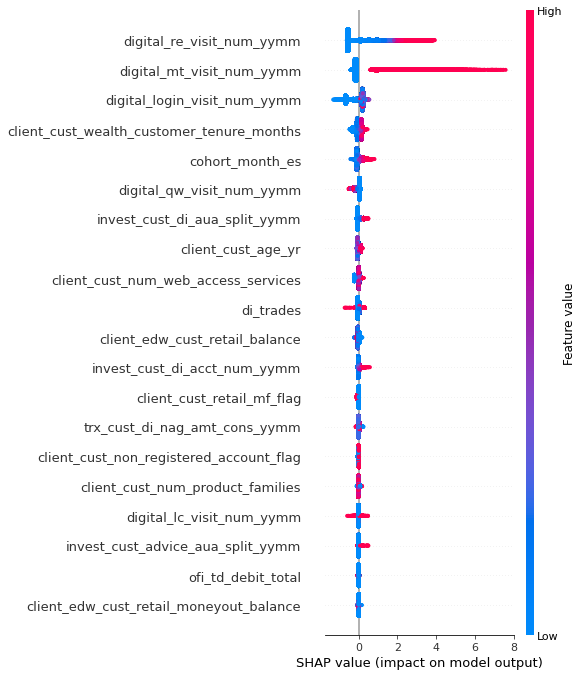

In [12]:
#shap_values = model.get_feature_importance(Pool(X, y), type='ShapValues')

# summarize the effects of all the features for CV model 2

expected_value = model_2_shap[0,-1]
shap_values = model_2_shap[:,:-1]
shap.summary_plot(shap_values, x)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


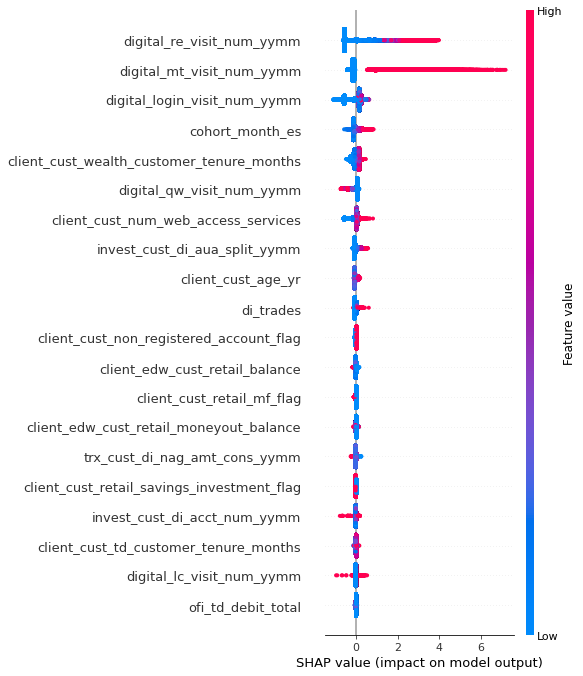

In [13]:
# summarize the effects of all the features for CV model 1

expected_value = model_1_shap[0,-1]
shap_values = model_1_shap[:,:-1]
shap.summary_plot(shap_values, x)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


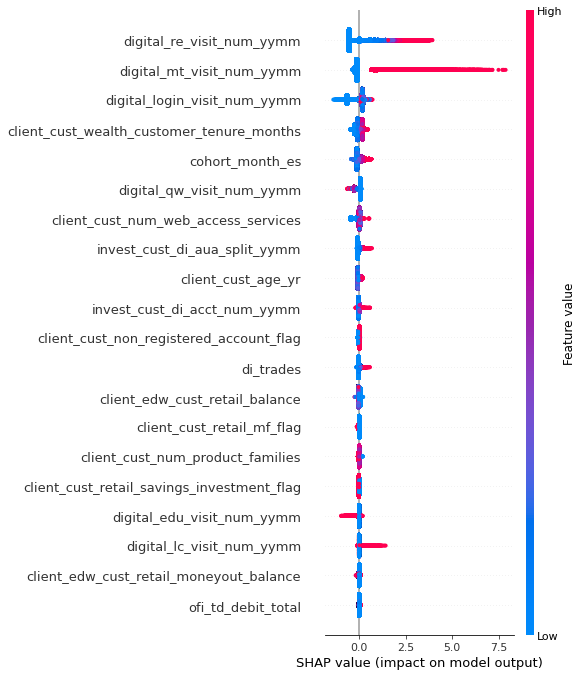

In [14]:
# summarize the effects of all the features for CV model 3

expected_value = model_3_shap[0,-1]
shap_values = model_3_shap[:,:-1]
shap.summary_plot(shap_values, x)

### Obtaining Propensity via averaging CV model scores

In [15]:
#Average out each CV model prediction as the final predict_proba
cv_models = scores[1]
cv_models_predict_proba = []

for model in list(range(0,3)):
    cv_models[model] = to_classifier(cv_models[model])
    pred = cv_models[model].predict_proba(x)
    cv_models_predict_proba.append(pred)
    

In [16]:
#assign average propensity (g_hat) and add to dataframe
g_hat = (cv_models_predict_proba[0][:,1] + cv_models_predict_proba[1][:,1] + cv_models_predict_proba[2][:,1])/3

df['g_hat'] = g_hat

In [17]:
df.head()

,cust_id,treatment_month,efectv_dt,attrited_pt_flag,treatment_status,mt_consumption_count_treatment_month,client_cust_new_wallet_size,client_cust_share_of_wallet,client_cust_new_wallet_size_band,client_edw_cust_retail_balance,client_cust_retail_flag,client_cust_non_registered_account_flag,client_cust_wealth_registered_account_flag,client_cust_num_product_families,client_cust_num_active_accounts,client_cust_num_retail_active_accounts,client_cust_num_nonretail_active_accounts,client_cust_retail_lending_flag,client_cust_retail_savings_investment_flag,client_cust_retail_mf_flag,client_cust_retail_term_deposit_flag,client_cust_retail_investment_other_flag,client_cust_wealth_customer_tenure_months,client_cust_age_yr,client_cust_num_web_access_services,client_cust_new_wealth_customer_flag,client_cust_td_customer_tenure_months,client_cust_num_products,client_cust_gross_income,invest_cust_di_acct_num_yymm,invest_cust_di_tfsa_acct_flag_yymm,invest_cust_di_aua_split_yymm,invest_cust_advice_acct_num_yymm,invest_cust_advice_aua_split_yymm,client_edw_cust_retail_moneyout_balance,cohort_month_es,avg_monthly_es,digital_re_visit_num_yymm,digital_re_visit_day_count_yymm,digital_mt_visit_num_yymm,digital_mt_visit_day_count_yymm,digital_lc_visit_num_yymm,digital_lc_visit_day_count_yymm,digital_edu_visit_num_yymm,digital_edu_visit_day_count_yymm,digital_qw_visit_num_yymm,digital_qw_visit_day_count_yymm,digital_login_visit_num_yymm,digital_login_distinct_visit_num_yymm,trx_cust_di_contribution_amt_cons_yymm,di_trades,trx_cust_di_nag_amt_cons_yymm,ofi_td_debit_total,ofi_td_credit_total,g_hat
0,-499410999999536,072022,2022-07-31,0,0,NaN,720005.58,1.0000,$500M - 750M,330929.74,1,1,1,4,9,5,4,1,1,0,0,0,174,49,4,0,210,8.0,43375.9594,4,1,13781.16,0,0.0,160.91,0.233992,0.433654,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,16.307692,11.615385,372.230769,36.769231,0.000000,0.384615,0.000000,0.000000,5656.184763,0.002296
1,-498680999999429,072022,2022-07-31,0,0,NaN,103175.29,1.0000,$100M - 250M,40427.51,1,0,1,4,8,4,4,1,1,1,0,0,75,50,10,0,210,8.0,87964.0998,4,1,10193.96,0,0.0,2059.36,0.359673,0.306174,0.000000,0.000000,0.083333,0.083333,0.0,0.0,0.0,0.0,9.384615,7.461538,31.769231,14.461538,0.000000,0.846154,90.607692,226.153846,0.000000,0.008098
2,-498564522778088,072022,2022-07-31,1,0,NaN,63075.05,0.0000,<$100M,0.00,0,0,1,1,1,0,1,0,0,0,0,0,19,45,0,0,19,1.0,80928.8872,1,0,0.00,0,0.0,0.00,0.000000,0.069148,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000726
3,-497700999999734,072022,2022-07-31,0,0,NaN,101853.84,0.0003,$100M - 250M,0.00,0,0,1,2,1,0,1,0,0,0,0,0,269,48,0,0,314,2.0,10000.0000,1,0,27.19,0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000927
4,-495723999999515,072022,2022-07-31,0,0,NaN,72285.25,0.3414,<$100M,9712.53,1,1,1,4,8,4,4,1,1,0,0,0,18,49,10,0,197,6.0,133023.2075,4,1,19286.17,0,0.0,10802.01,0.601984,0.755566,0.461538,0.461538,0.000000,0.000000,0.0,0.0,0.0,0.0,3.846154,3.384615,120.923077,62.000000,156.036923,0.153846,-171.807692,0.000000,38.750769,0.018613


## Propensity Methods for Causal Inference

### Matching

In [18]:
#Code by Kellie Ottoboni's package pscore_match http://www.kellieottoboni.com/pscore_match/_modules/pscore_match/match.html
"""
This module implements several variants of matching: 
one-to-one matching, one-to-many matching, with or without a caliper, 
and without or without replacement. 
Variants of the methods are examined in Austin (2014).


Austin, P. C. (2014), A comparison of 12 algorithms for matching on the 
propensity score. Statistic. Med., 33: 1057-1069.
"""

from __future__ import division
import numpy as np
import scipy
from scipy.stats import binom, hypergeom, gaussian_kde, ttest_ind, ranksums
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

################################################################################
################################# utils ########################################
################################################################################

def set_caliper(caliper_scale, caliper, propensity):
    # Check inputs
    if caliper_scale == None:
        caliper = 0
    if not(0<=caliper<1):
        if caliper_scale == "propensity" and caliper>1:
            raise ValueError('Caliper for "propensity" method must be between 0 and 1')
        elif caliper<0:
            raise ValueError('Caliper cannot be negative')

    # Transform the propensity scores and caliper when caliper_scale is "logit" or None
    if caliper_scale == "logit":
        propensity = np.log(propensity/(1-propensity))
        caliper = caliper*np.std(propensity)
    return caliper
    
    caliper = np.std(df['propensity_logit']) * 0.2 
def recode_groups(groups, propensity):
    # Code groups as 0 and 1
    groups = (groups == groups.unique()[0])
    N = len(groups)
    N1 = groups[groups == 1].index
    N2 = groups[groups == 0].index
    g1 = propensity[groups == 1]
    g2 = propensity[groups == 0]
    # Check if treatment groups got flipped - the smaller should correspond to N1/g1
    if len(N1) > len(N2):
       N1, N2, g1, g2 = N2, N1, g2, g1
    return groups, N1, N2, g1, g2

################################################################################
############################# Base Matching Class ##############################
################################################################################

class Match(object):
    """
    Parameters
    ----------
    groups : array-like 
        treatment assignments, must be 2 groups
    propensity : array-like 
        object containing propensity scores for each observation. 
        Propensity and groups should be in the same order (matching indices)    
    """
    
    def __init__(self, groups, propensity):
        self.groups = pd.Series(groups)
        self.propensity = pd.Series(propensity)
        assert self.groups.shape==self.propensity.shape, "Input dimensions dont match"
        assert all(self.propensity >=0) and all(self.propensity <=1), "Propensity scores must be between 0 and 1"
        assert len(np.unique(self.groups)==2), "Wrong number of groups"
        self.nobs = self.groups.shape[0]
        self.ntreat = np.sum(self.groups == 1)
        self.ncontrol = np.sum(self.groups == 0)
        
    def create(self, method='one-to-one', **kwargs):
        """
        Parameters
        ----------
        method : string
            'one-to-one' (default) or 'many-to-one'
        caliper_scale: string
            "propensity" (default) if caliper is a maximum difference in propensity scores,
            "logit" if caliper is a maximum SD of logit propensity, or "none" for no caliper
        caliper : float
             specifies maximum distance (difference in propensity scores or SD of logit propensity) 
        replace : bool
            should individuals from the larger group be allowed to match multiple individuals in the smaller group?
            (default is False)
    
        Returns
        -------
        A series containing the individuals in the control group matched to the treatment group.
        Note that with caliper matching, not every treated individual may have a match.
        """

        if method=='many-to-one':
            self._match_many(**kwargs)
            self._match_info()
        elif method=='one-to-one':
            self._match_one(**kwargs)
            self._match_info()
        else:
            raise ValueError('Invalid matching method')

    def _match_one(self, caliper_scale=None, caliper=0.05, replace=False):
        """
        Implements greedy one-to-one matching on propensity scores.

        Parameters
        ----------
        caliper_scale: string
            "propensity" (default) if caliper is a maximum difference in propensity scores,
            "logit" if caliper is a maximum SD of logit propensity, or "none" for no caliper
        caliper : float
             specifies maximum distance (difference in propensity scores or SD of logit propensity) 
        replace : bool
            should individuals from the larger group be allowed to match multiple individuals in the smaller group?
            (default is False)
        """
        caliper = set_caliper(caliper_scale, caliper, self.propensity)
        groups, N1, N2, g1, g2 = recode_groups(self.groups, self.propensity)
        
        # Randomly permute the smaller group to get order for matching
        morder = np.random.permutation(N1)
        matches = {}

        for m in morder:
            dist = abs(g1[m] - g2)
            if (dist.min() <= caliper) or not caliper:
                matches[m] = dist.idxmin()    # replace argmin() with idxmin()
                if not replace:
                    g2 = g2.drop(matches[m])
        self.matches = matches
        self.weights = np.zeros(self.nobs)
        self.freq = np.zeros(self.nobs)
        mk = list(matches.keys())
        mv = list(matches.values())
        for i in range(len(matches)):
            self.freq[mk[i]] += 1
            self.weights[mk[i]] += 1
            self.freq[mv[i]] += 1
            self.weights[mv[i]] += 1 

    

    def _match_info(self):
        """
        Helper function to create match info
        """
        assert self.matches is not None, 'No matches yet!'
        
#         self.matches = {
#             'match_pairs' : self.matches,
# #             'treated' : np.unique(list(self.matches.keys())),
# #             'control' : np.unique(list(self.matches.values()))
#         }
        self.treated = { 'treated' : list(np.unique(list(self.matches.keys())))
        
        }
        self.control = {
            'control' : np.unique(self.matches.values())
        }
#         self.matches['dropped'] = np.setdiff1d(list(range(self.nobs)), 
#                                     np.append(self.matches['treated'], self.matches['control']))

    


################################################################################
############################ helper funcs  #####################################
################################################################################

def whichMatched(matches, data, show_duplicates = True):
    """ 
    Simple function to convert output of Matches to DataFrame of all matched observations
    
    Parameters
    ----------
    matches : Match
        Match class object with matches already fit
    data : DataFrame 
        Dataframe with unique rows, for which we want to create new matched data.
        This may be a dataframe of covariates, treatment, outcome, or any combination.
    show_duplicates : bool
        Should repeated matches be included as multiple rows? Default is True.
        If False, then duplicates appear as one row but a column of weights is
        added.
    
    Returns
    -------
    DataFrame containing only the treatment group and matched controls,
    with the same columns as input data
    """
    
    if show_duplicates:
        indices = []
        for i in range(len(matches.freq)):
            j = matches.freq[i]
            while j>0:
                indices.append(i)
                j -= 1
        return data.loc[indices] # replace ix with loc
    else:
        dat2 = data.copy()
        dat2['weights'] = matches.weights
        dat2['frequency'] = matches.freq
        keep = dat2['frequency'] > 0
        return dat2.loc[keep]


def rank_test(covariates, groups):
    """ 
    Wilcoxon rank sum test for the distribution of treatment and control covariates.
    
    Parameters
    ----------
    covariates : DataFrame 
        Dataframe with one covariate per column.
        If matches are with replacement, then duplicates should be 
        included as additional rows.
    groups : array-like
        treatment assignments, must be 2 groups
    
    Returns
    -------
    A list of p-values, one for each column in covariates
    """    
    colnames = list(covariates.columns)
    J = len(colnames)
    pvalues = np.zeros(J)
    for j in range(J):
        var = covariates[colnames[j]]
        res = ranksums(var[groups == 1], var[groups == 0])
        pvalues[j] = res.pvalue
    return pvalues
    

def t_test(covariates, groups):
    """ 
    Two sample t test for the distribution of treatment and control covariates
    
    Parameters
    ----------
    covariates : DataFrame 
        Dataframe with one covariate per column.
        If matches are with replacement, then duplicates should be 
        included as additional rows.
    groups : array-like
        treatment assignments, must be 2 groups
    
    Returns
    -------
    A list of p-values, one for each column in covariates
    """
    colnames = list(covariates.columns)
    J = len(colnames)
    pvalues = np.zeros(J)
    for j in range(J):
        var = covariates[colnames[j]]
        res = ttest_ind(var[groups == 1], var[groups == 0],nan_policy='omit')
        pvalues[j] = res.pvalue
    return pvalues
    
def cohenD (tmp, metricName):
    treated_metric = tmp[tmp.treatment == 1][metricName]
    untreated_metric = tmp[tmp.treatment == 0][metricName]
    
    d = ( treated_metric.mean() - untreated_metric.mean() ) / math.sqrt(((treated_metric.count()-1)*treated_metric.std()**2 + (untreated_metric.count()-1)*untreated_metric.std()**2) / (treated_metric.count() + untreated_metric.count()-2))
    return d

def ks_2samp(covariates, groups):
    """ 
    Two sample t test for the distribution of treatment and control covariates
    
    Parameters
    ----------
    covariates : DataFrame 
        Dataframe with one covariate per column.
        If matches are with replacement, then duplicates should be 
        included as additional rows.
    groups : array-like
        treatment assignments, must be 2 groups
    
    Returns
    -------
    A list of p-values, one for each column in covariates
    """
    colnames = list(covariates.columns)
    J = len(colnames)
    pvalues = np.zeros(J)
    for j in range(J):
        var = covariates[colnames[j]]
        res = stat.ks_2samp(var[groups == 1], var[groups == 0],alternative='two-sided')
        pvalues[j] = res.pvalue
    return pvalues

In [19]:
#set seed here for reproducibility of results
np.random.seed(2023)

#Assign groups and propensities
treatment = df.treatment_status
pscore = df.g_hat
g1_1_wor = Match(treatment,pscore)

In [20]:
#create the match object. 

"""
Note here the "caliper" hyperparameter is the percentage of the propensity score's (or logit of propensity score's) standard deviation to use.
caliper = 0.2, caliper_scale = 'logit' means the 0.2*(std.dev of the propensity score logit) will be used as the caliper size.
This size is recommended following (Austin, 2014)'s meta analysis (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4285163/)

"""


"""
The problem with the above approach is that the derived caliper value is around .28, or 28% propensity error. Given the imbalance in our data and the size of the non-treatment group,
we get a better match result with a much smaller caliper (i.e 1% of actual propensity)

"""
#Logit, 0.2
#g1_1_wor.create(method='one-to-one', caliper_scale='logit', caliper=0.2, replace=False)

#Smaller Caliper (i.e 1% score difference)
g1_1_wor.create(method='one-to-one', caliper_scale='propensity', caliper=0.01, replace=False)

In [24]:
##Created matched dataframe, report feature mean and count

data_matched = whichMatched(g1_1_wor, df, show_duplicates = False)
# data_matched.pivot_table(values=features_list,
#                          index='treatment_status',
#                          aggfunc=[np.mean, np.size],
#                          margins=True
# )

# #Write matched dataset into HIVE for storage (as matching algo takes a long time to run)
# sp_df_data_matched = spark.createDataFrame(data_matched)

# # sp_df_data_matched.write.mode("overwrite").format("hive").saveAsTable("advanced_analytics.mt_psm_1_1_matched_data")

# sp_df_data_matched.createOrReplaceTempView('sp_df_data_matched')

# drop=spark.sql("drop table if exists advanced_analytics.mt_retention_psm_data_{MMYYYY} purge".format(MMYYYY=MMYYYY))
# write=spark.sql("create table if not exists advanced_analytics.mt_retention_psm_data_{MMYYYY} as select * from sp_df_data_matched".format(cohort=cohort))

In [23]:
#save data into csv (HEAT issues)
data_matched.to_csv('mt_retention_PSM_1_1_match_data.csv')

# Assessing Match Quality

### Visual Inspection

In [8]:
#load matched data from saved csv
data_matched = pd.read_csv('mt_retention_PSM_1_1_match_data.csv')

In [15]:
log_kde_features = [
    'client_cust_new_wallet_size'
    ,'client_edw_cust_retail_balance'
    ,'client_cust_gross_income'
    ,'invest_cust_di_aua_split_yymm'
    , 'invest_cust_advice_acct_num_yymm'
    , 'invest_cust_advice_aua_split_yymm'
    , 'client_edw_cust_retail_moneyout_balance'
    , 'trx_cust_di_contribution_amt_cons_yymm'
    , 'di_trades'
    , 'trx_cust_di_nag_amt_cons_yymm'
    , 'ofi_td_debit_total'
    , 'ofi_td_credit_total'
    ]

kde_features = [feature for feature in features_list if feature not in log_kde_features]
kde_features.remove('client_cust_new_wallet_size_band')

In [46]:
#Functions for distribution plotting via histograms. May provide a more informative visual than using KDE

def comparison_plot_hist(data, data_matched, feature, log_scale=False):
    plt.close()
    plt.figure()
    f, axes = plt.subplots(1, 2, figsize=(15, 5))
    plt.subplot(121)
    sns.kdeplot(data = data[data['treatment_status']==1], x = feature,  ax = axes[0], log_scale = log_scale, label = 'Consumed MT').set()
    sns.kdeplot(data = data[data['treatment_status']==0], x = feature,  ax = axes[0], log_scale = log_scale, color='orange', label = 'Did not consume MT')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend(loc="upper left")
    plt.title('Before Matching')

    plt.subplot(122)
    sns.kdeplot(data = data_matched[data_matched['treatment_status']==1], x = feature,  ax = axes[1], log_scale = log_scale, label = 'Consumed MT').set()
    sns.kdeplot(data = data_matched[data_matched['treatment_status']==0], x = feature,  ax = axes[1], log_scale = log_scale, color='orange', label = 'Did not consume MT')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title('After Matching')
    plt.legend(loc="upper left")
    plt.show()
    
def comparison_plot_cat(data, data_matched, feature):
    comparison_before = pd.DataFrame({'Treatment':data[data['treatment_status']==1][feature].value_counts(normalize=True),
                                      'Control':data[data['treatment_status']==0][feature].value_counts(normalize=True)})
    comparison_after = pd.DataFrame({'Treatment':data_matched[data_matched['treatment_status']==1][feature].value_counts(normalize=True),
                                     'Control':data_matched[data_matched['treatment_status']==0][feature].value_counts(normalize=True)})

 

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30,5))
    comparison_before.sort_values('Treatment', ascending=False).plot(y=['Treatment', 'Control'], kind='bar', figsize=(15,5), alpha=0.5, ax=ax1)
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Density')
    ax1.set_title('Before Matching')
    comparison_after.sort_values('Treatment', ascending=False).plot(y=['Treatment', 'Control'], kind='bar', figsize=(15,5), alpha=0.5, ax=ax2)
    ax2.set_xlabel(feature)
    ax2.set_ylabel('Density')
    ax2.set_title('After Matching')
    plt.show()

/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 432x288 with 0 Axes>

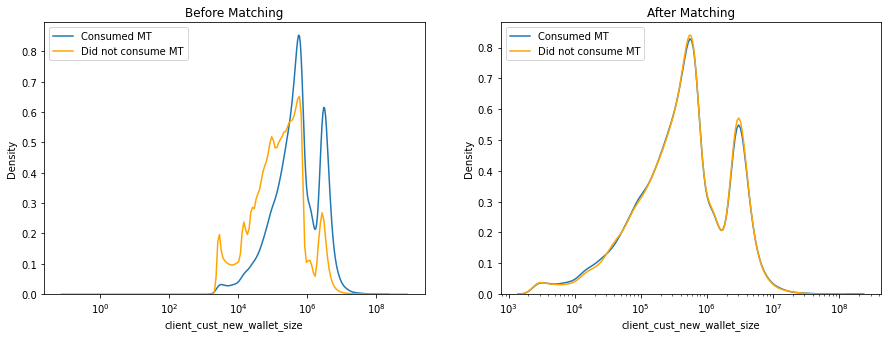

/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 432x288 with 0 Axes>

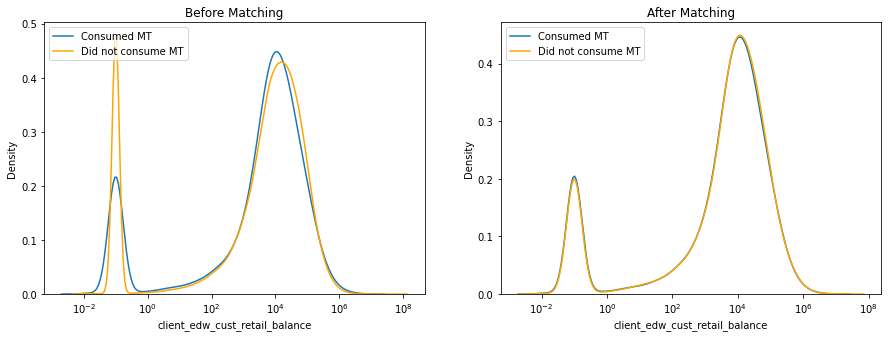

<Figure size 432x288 with 0 Axes>

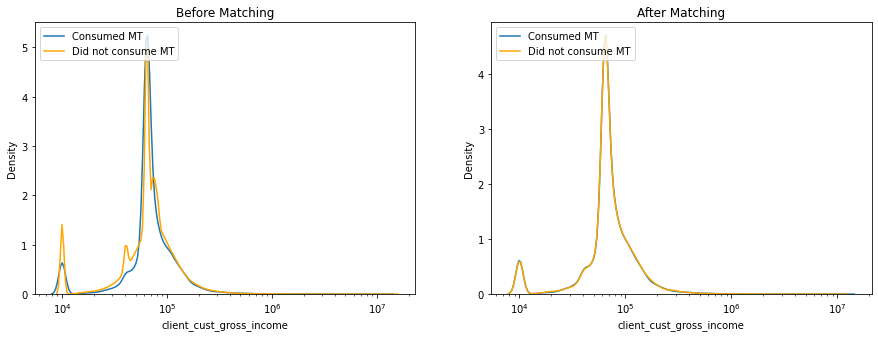

/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 432x288 with 0 Axes>

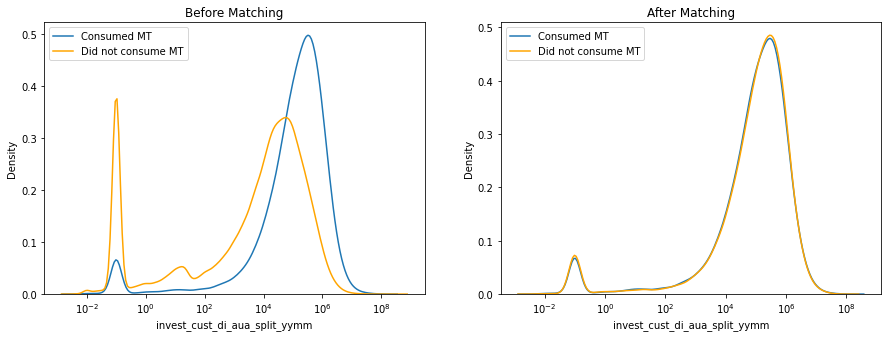

<Figure size 432x288 with 0 Axes>

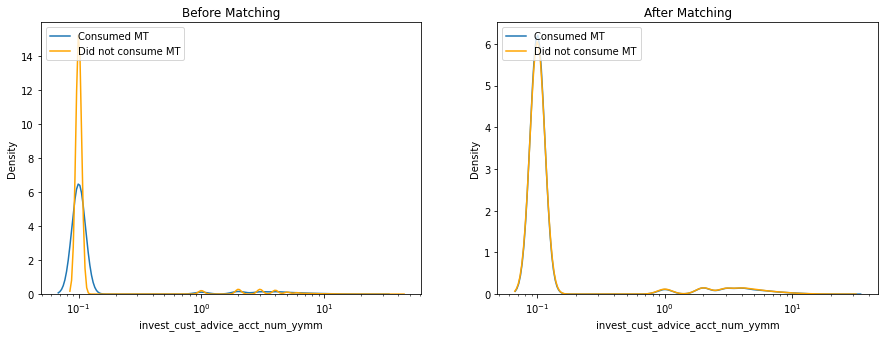

/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 432x288 with 0 Axes>

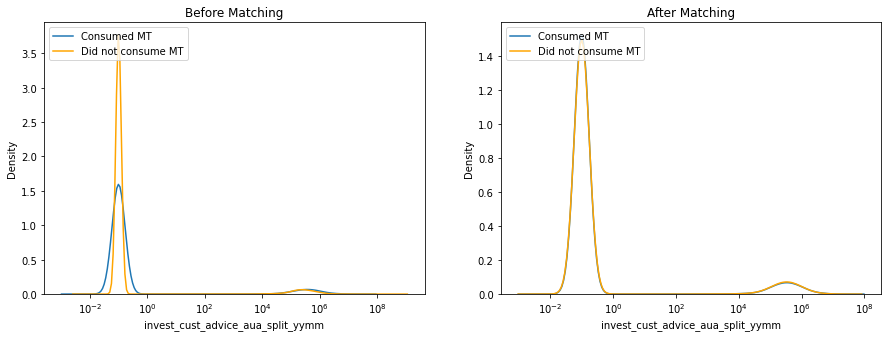

/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 432x288 with 0 Axes>

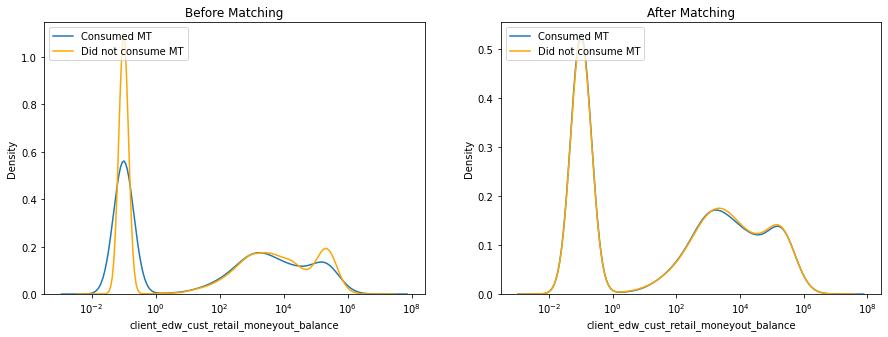

/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 432x288 with 0 Axes>

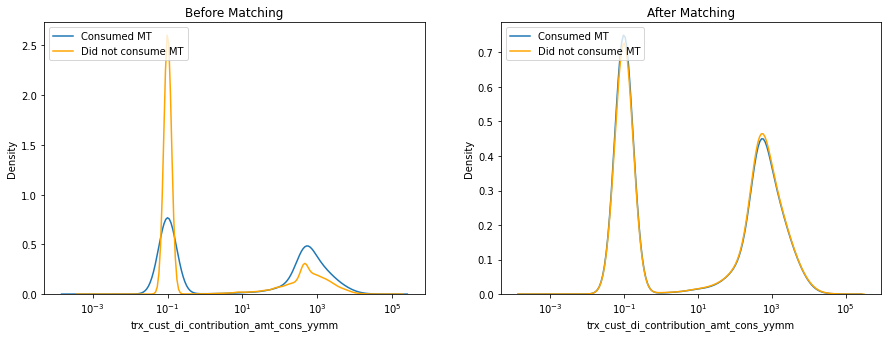

<Figure size 432x288 with 0 Axes>

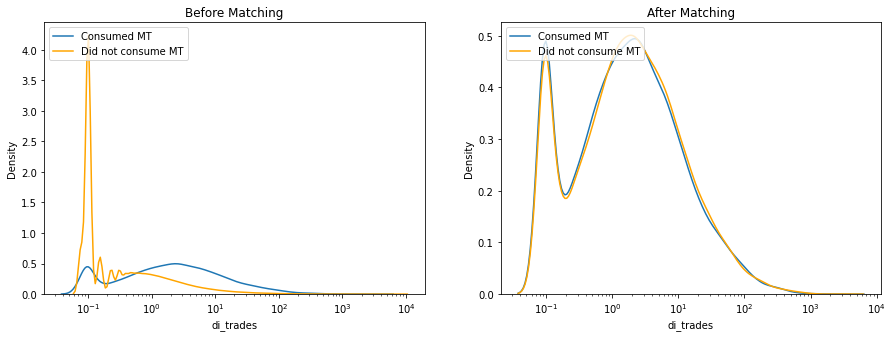

/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lz/tenantspace/ida/anp/cawmwim1/leetom8/.venv/causal_inference/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 432x288 with 0 Axes>

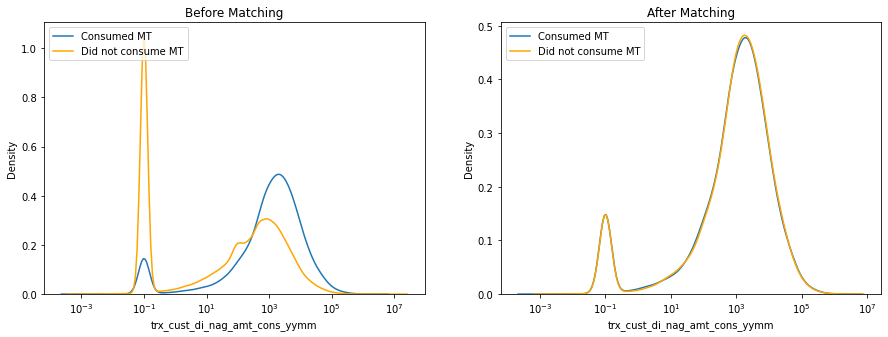

<Figure size 432x288 with 0 Axes>

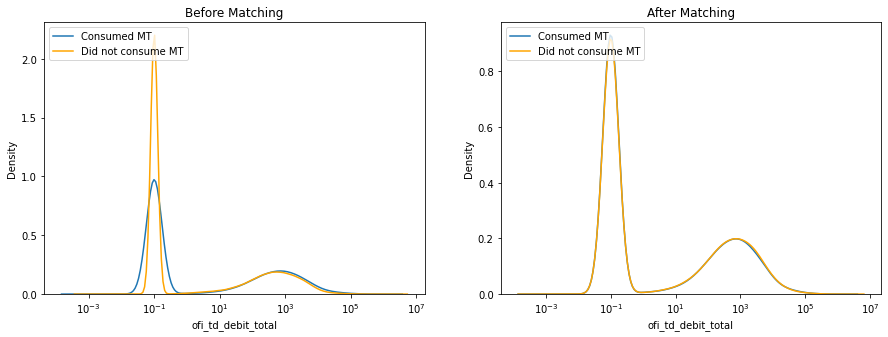

<Figure size 432x288 with 0 Axes>

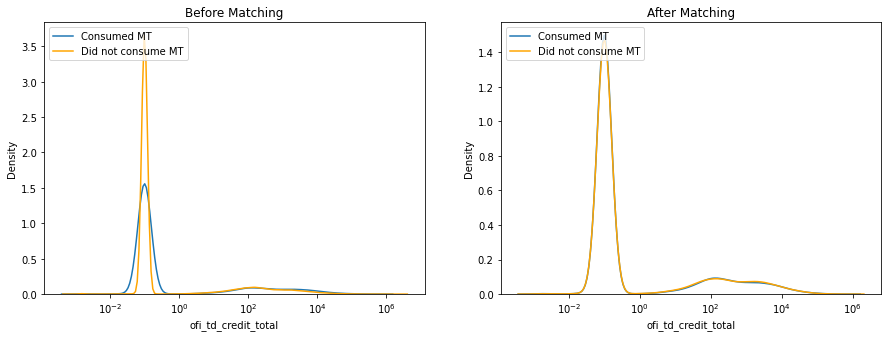

In [53]:
#Numeric features requiring a log scale -replace 0 with 0.1 for plotting purposes as log_scale cannot divide by 0
df_test = df
df_test[log_kde_features] = df_test[log_kde_features].replace(0,0.1)

data_matched_test = data_matched
data_matched_test[log_kde_features] = data_matched_test[log_kde_features].replace(0,0.1)

for feature in log_kde_features:
    comparison_plot_hist(df_test,data_matched_test,feature, log_scale=True)

<Figure size 432x288 with 0 Axes>

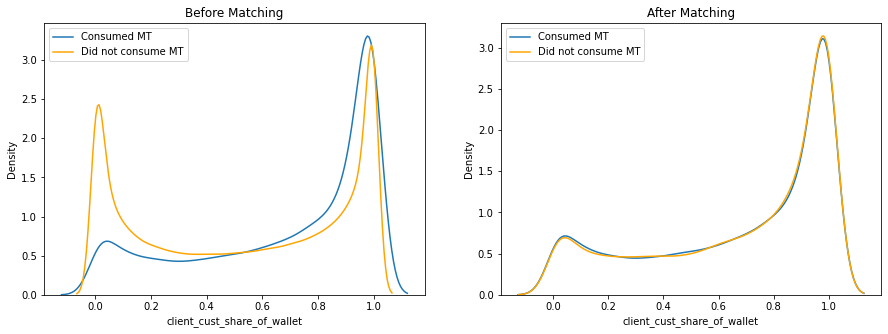

<Figure size 432x288 with 0 Axes>

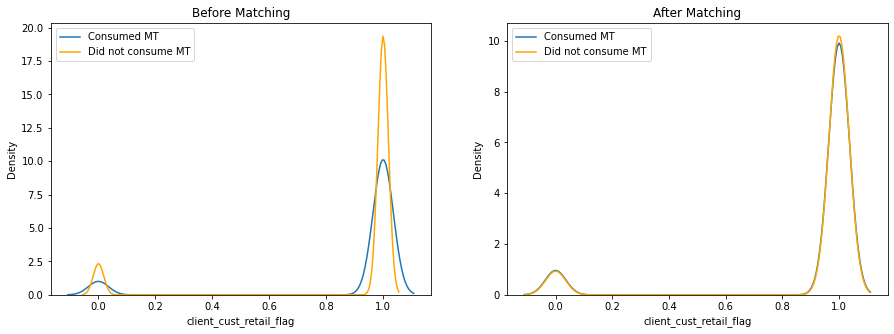

<Figure size 432x288 with 0 Axes>

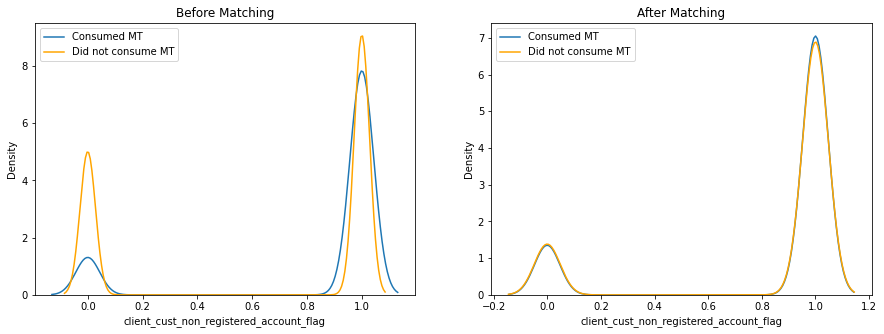

<Figure size 432x288 with 0 Axes>

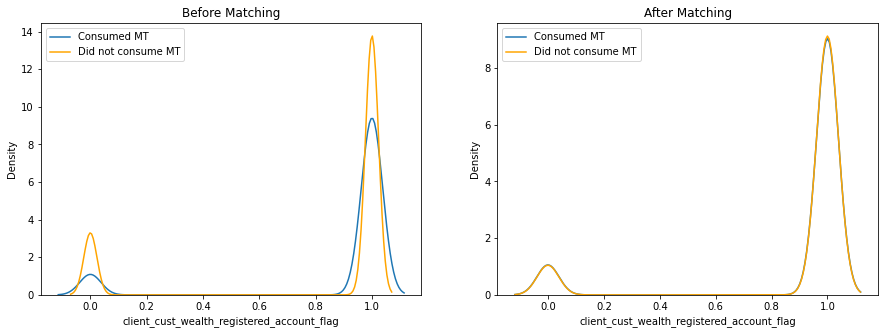

<Figure size 432x288 with 0 Axes>

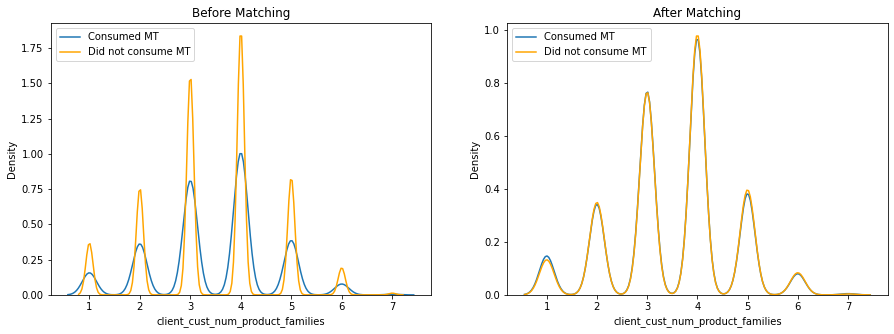

<Figure size 432x288 with 0 Axes>

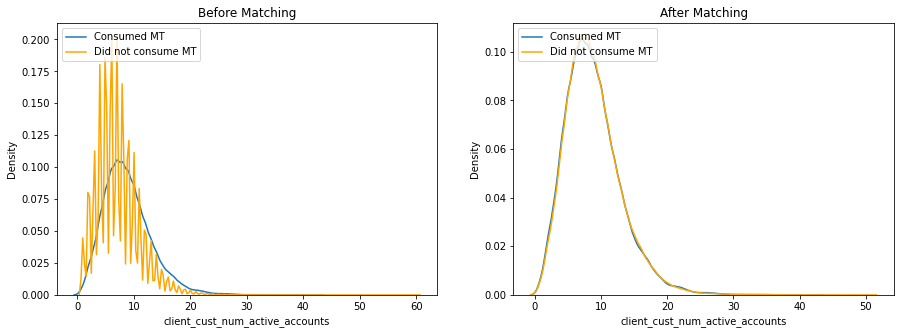

<Figure size 432x288 with 0 Axes>

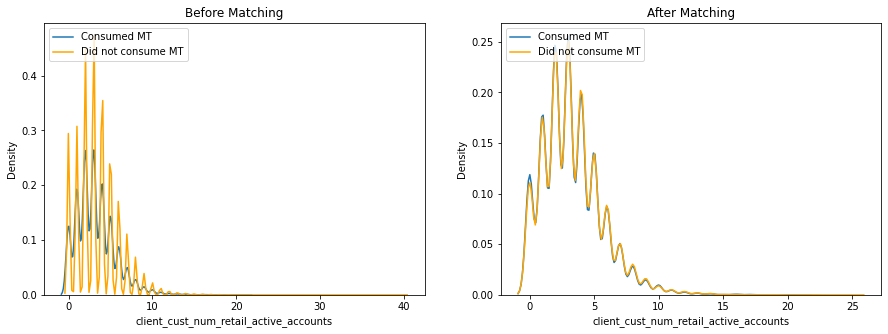

<Figure size 432x288 with 0 Axes>

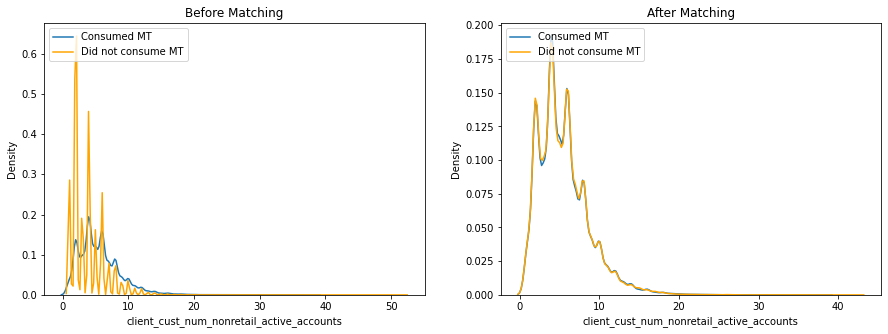

<Figure size 432x288 with 0 Axes>

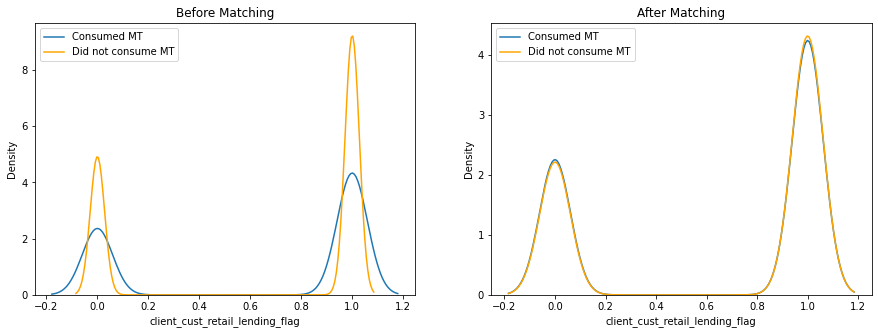

<Figure size 432x288 with 0 Axes>

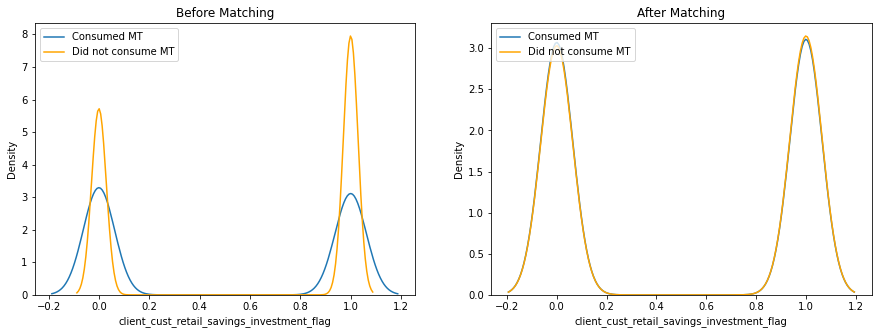

<Figure size 432x288 with 0 Axes>

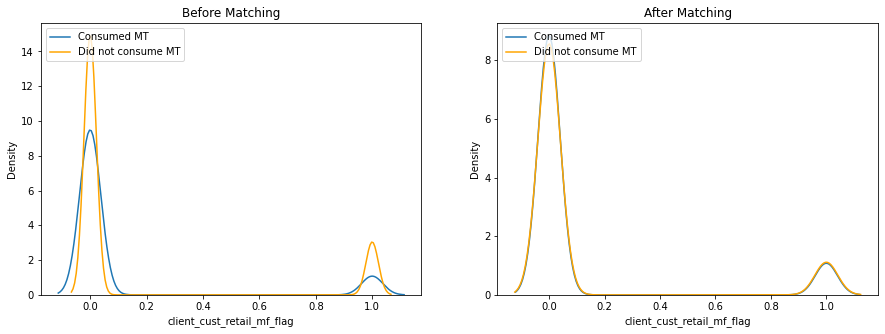

<Figure size 432x288 with 0 Axes>

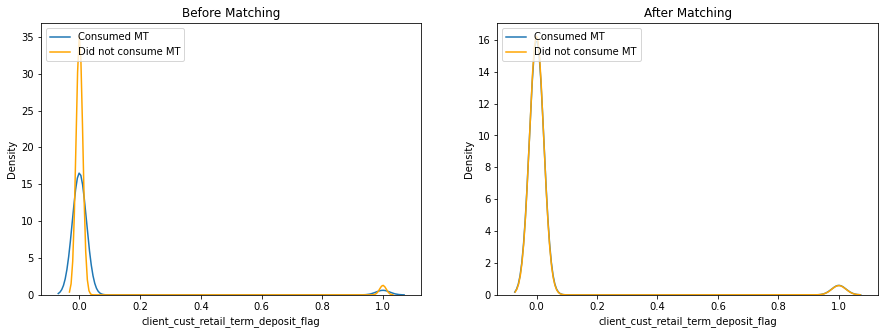

<Figure size 432x288 with 0 Axes>

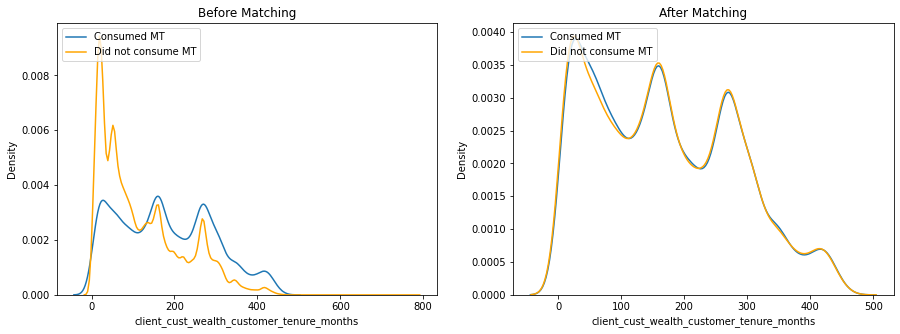

<Figure size 432x288 with 0 Axes>

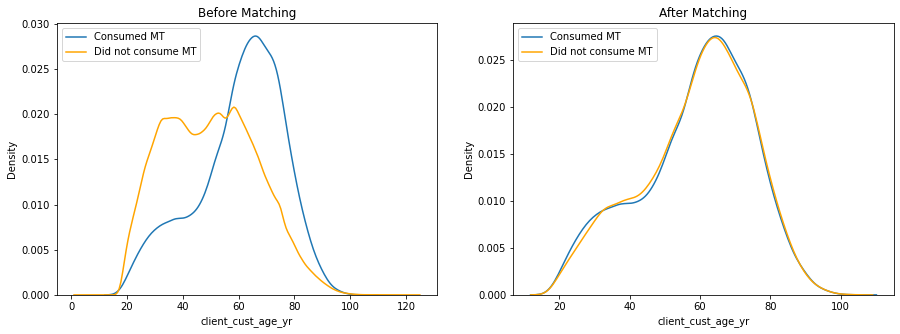

<Figure size 432x288 with 0 Axes>

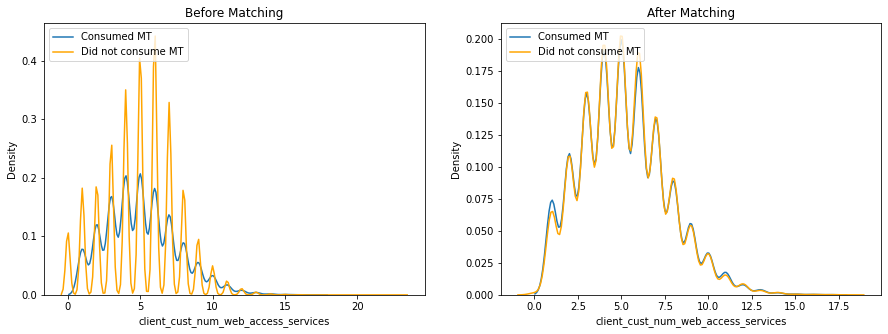

<Figure size 432x288 with 0 Axes>

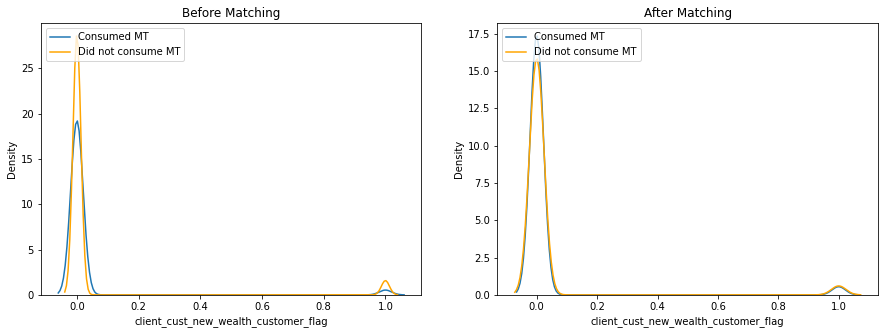

<Figure size 432x288 with 0 Axes>

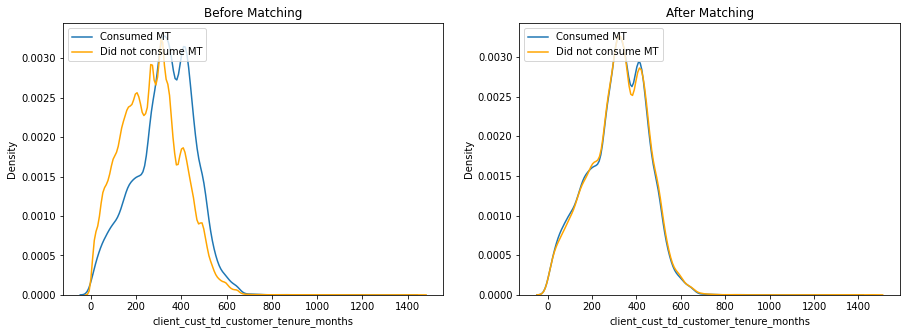

<Figure size 432x288 with 0 Axes>

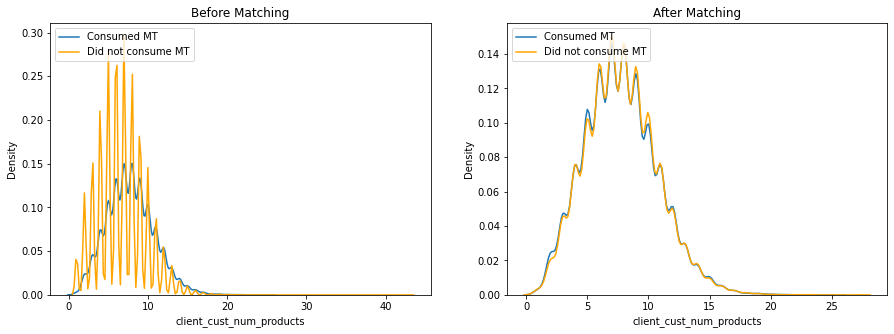

<Figure size 432x288 with 0 Axes>

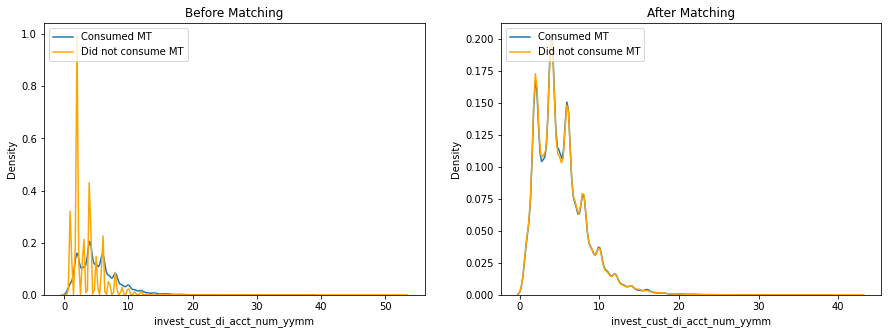

<Figure size 432x288 with 0 Axes>

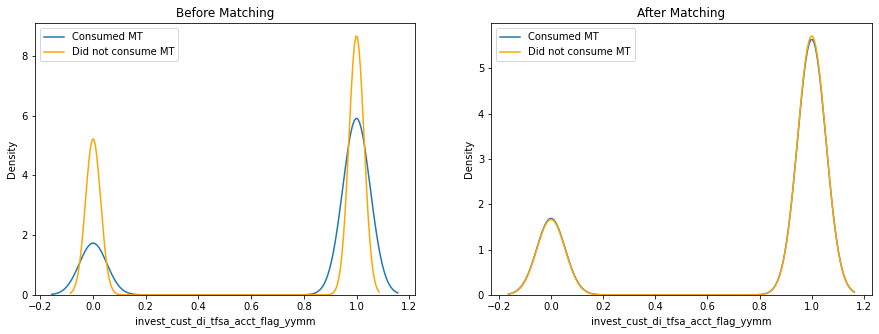

<Figure size 432x288 with 0 Axes>

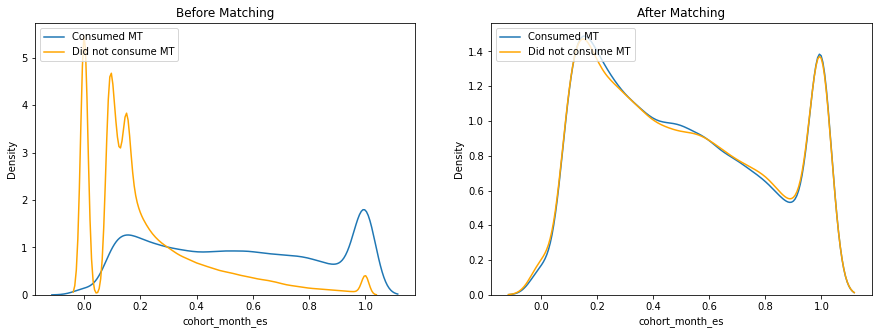

<Figure size 432x288 with 0 Axes>

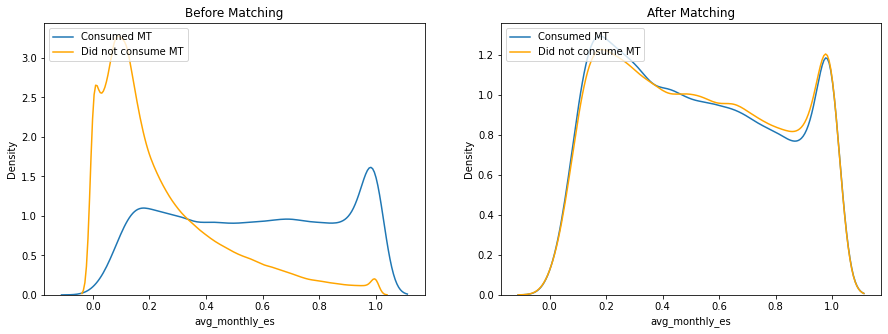

<Figure size 432x288 with 0 Axes>

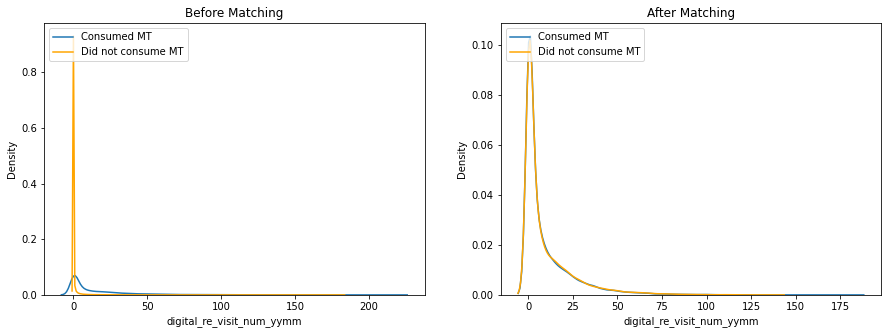

<Figure size 432x288 with 0 Axes>

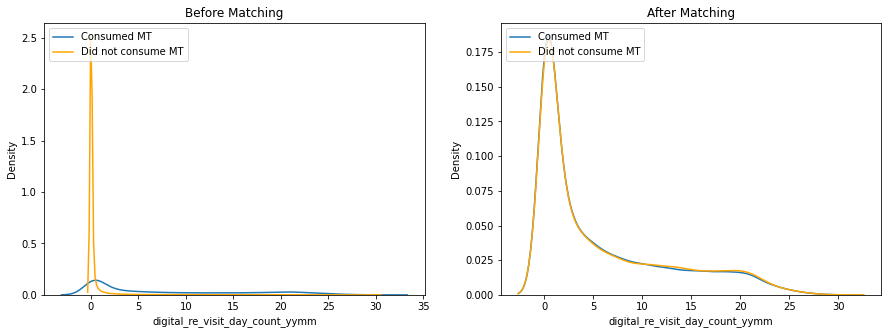

<Figure size 432x288 with 0 Axes>

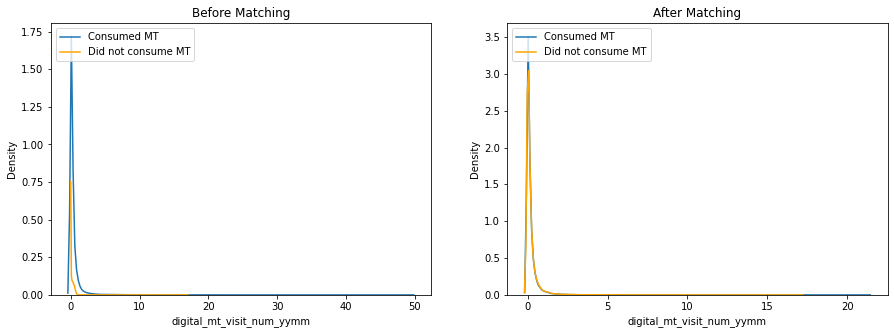

<Figure size 432x288 with 0 Axes>

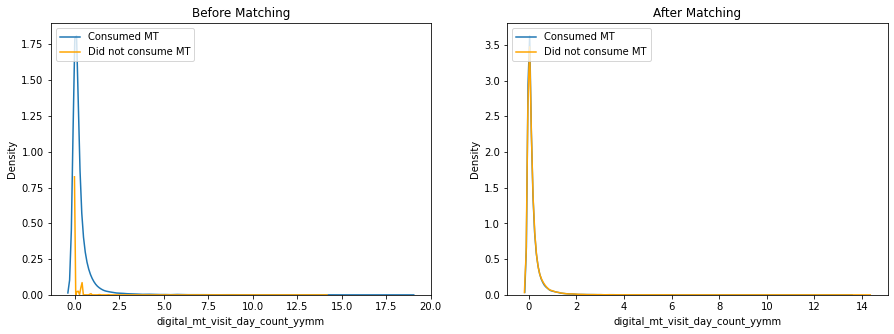

<Figure size 432x288 with 0 Axes>

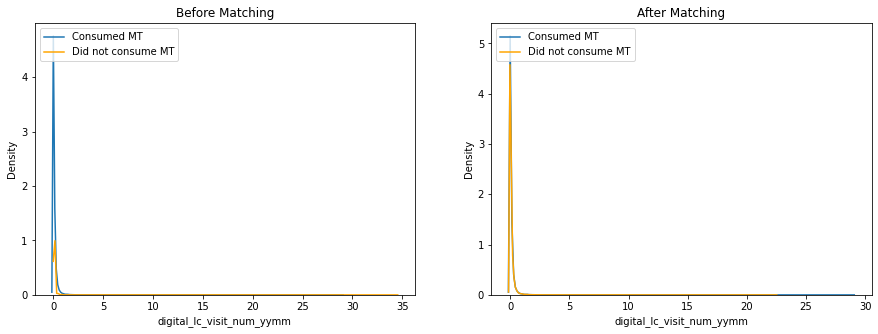

<Figure size 432x288 with 0 Axes>

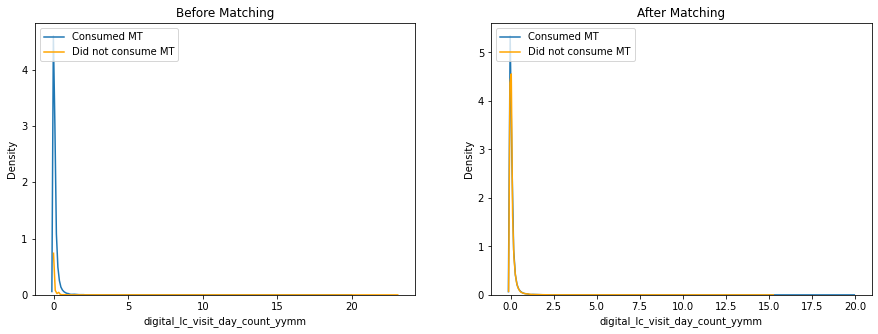

<Figure size 432x288 with 0 Axes>

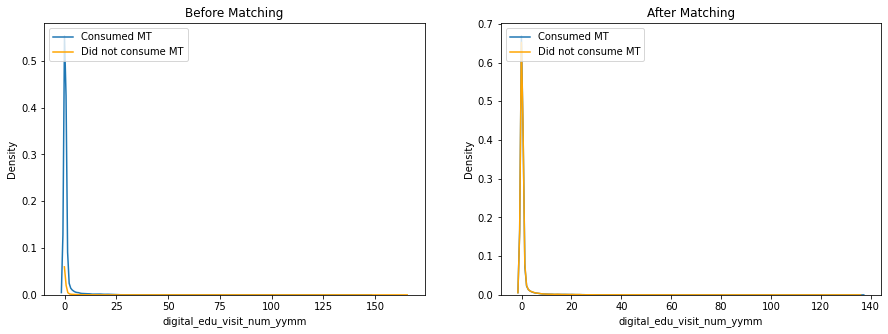

<Figure size 432x288 with 0 Axes>

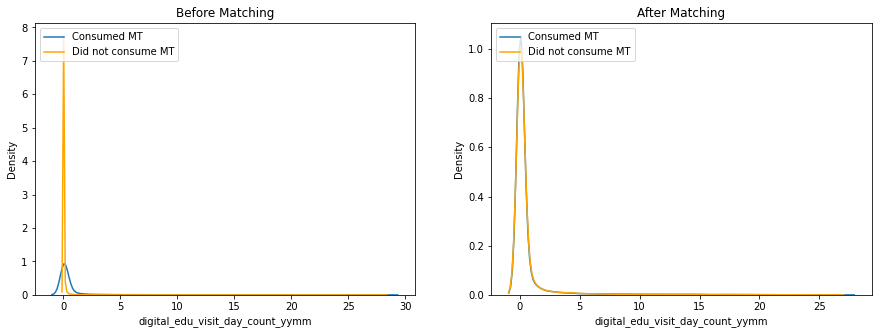

<Figure size 432x288 with 0 Axes>

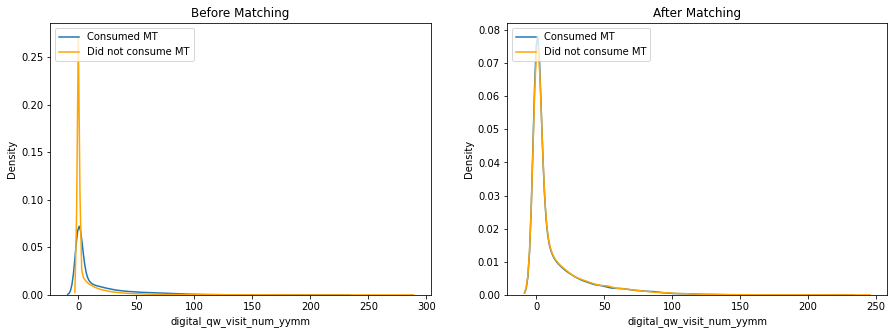

<Figure size 432x288 with 0 Axes>

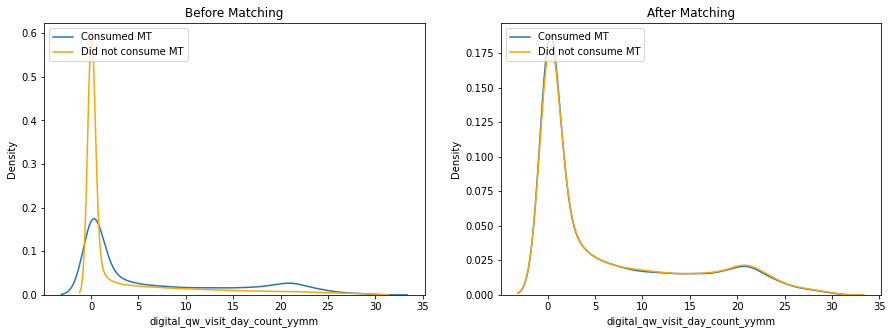

<Figure size 432x288 with 0 Axes>

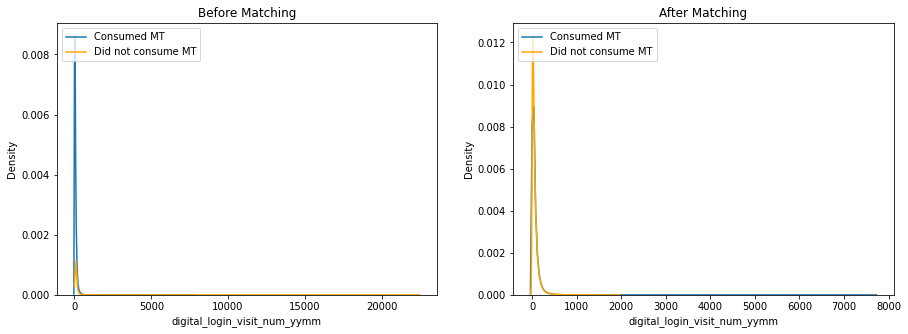

<Figure size 432x288 with 0 Axes>

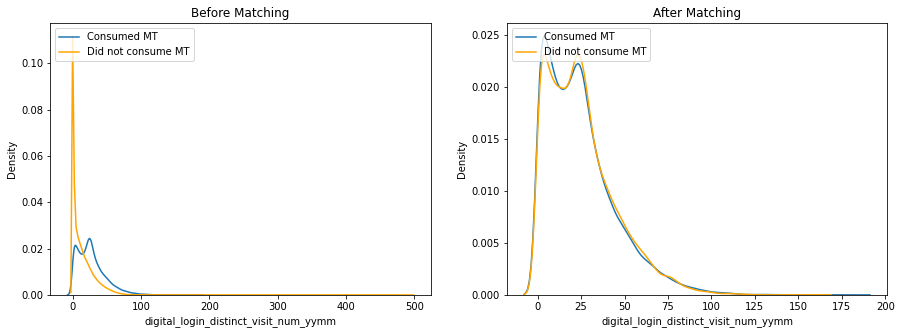

In [55]:
#Numeric features not requiring a log scale
for feature in kde_features:
    comparison_plot_hist(df,data_matched,feature)

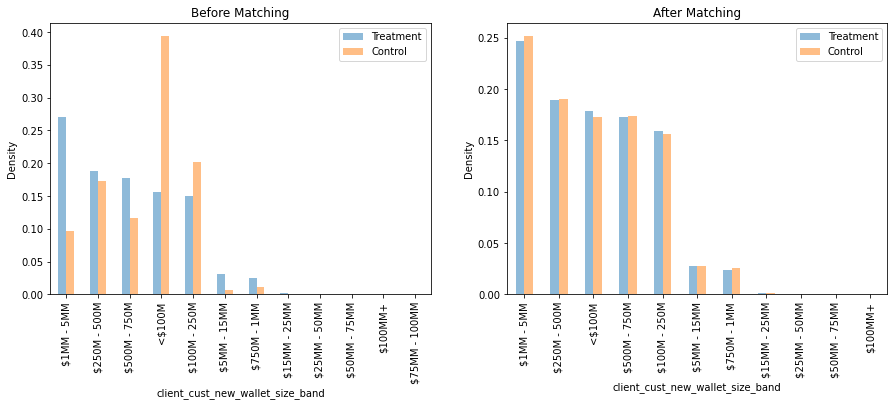

In [45]:
comparison_plot_cat(df,data_matched,'client_cust_new_wallet_size_band')

### Statistical Tests

In [60]:
features_list

['client_cust_new_wallet_size',
 'client_cust_share_of_wallet',
 'client_edw_cust_retail_balance',
 'client_cust_retail_flag',
 'client_cust_non_registered_account_flag',
 'client_cust_wealth_registered_account_flag',
 'client_cust_num_product_families',
 'client_cust_num_active_accounts',
 'client_cust_num_retail_active_accounts',
 'client_cust_num_nonretail_active_accounts',
 'client_cust_retail_lending_flag',
 'client_cust_retail_savings_investment_flag',
 'client_cust_retail_mf_flag',
 'client_cust_retail_term_deposit_flag',
 'client_cust_wealth_customer_tenure_months',
 'client_cust_age_yr',
 'client_cust_num_web_access_services',
 'client_cust_new_wealth_customer_flag',
 'client_cust_td_customer_tenure_months',
 'client_cust_num_products',
 'client_cust_gross_income',
 'invest_cust_di_acct_num_yymm',
 'invest_cust_di_tfsa_acct_flag_yymm',
 'invest_cust_di_aua_split_yymm',
 'invest_cust_advice_acct_num_yymm',
 'invest_cust_advice_aua_split_yymm',
 'client_edw_cust_retail_moneyout_

In [90]:
#Stat Test Pvalues, before and after matching

#Before Matching

for col in features_list:
    x=np.array(df[df['treatment_status']==1][col])
    y=np.array(df[df['treatment_status']==0][col])
    if np.array_equal(x, x.astype(bool)) & np.array_equal(y, y.astype(bool)):
        count = np.array([np.sum(x), np.sum(y)])
        nobs = np.array([x.size, y.size])
        a, pval2 = proportions_ztest(count, nobs)
        print('feature: ', col)
        print('proportions_ztest pval: ', pval2)
        print('*************************************************************************************************')
    else:
        pval=ttest_ind(x, y,nan_policy='omit').pvalue
        wilcoxon_ranksum_pval=ranksums(x, y).pvalue
        ks_2samp_pval=stat.ks_2samp(x, y, alternative='two-sided').pvalue
    #print(col,'- T-Test/proportion ztest: ',pval, '','*** Wilcoxon Rank Sum:',wilcoxon_ranksum_pval, '*** KS GoF Test',ks_2samp_pval)
    #for excel copying
    print('feature: ', col)
    print('ttest_ind pval: ', pval, ',','wilcoxon_ranksum_pval: ', wilcoxon_ranksum_pval,',','ks_2samp_pval: ', ks_2samp_pval)
    print('*************************************************************************************************')

feature:  client_cust_new_wallet_size
ttest_ind pval:  0.0 , wilcoxon_ranksum_pval:  0.0 , ks_2samp_pval:  0.0
*************************************************************************************************
feature:  client_cust_share_of_wallet
ttest_ind pval:  0.0 , wilcoxon_ranksum_pval:  0.0 , ks_2samp_pval:  0.0
*************************************************************************************************
feature:  client_edw_cust_retail_balance
ttest_ind pval:  0.31667520771951974 , wilcoxon_ranksum_pval:  0.015477624529979202 , ks_2samp_pval:  1.2002003035969026e-24
*************************************************************************************************
feature:  client_cust_retail_flag
proportions_ztest pval:  1.6743197779798804e-23
*************************************************************************************************
feature:  client_cust_retail_flag
ttest_ind pval:  0.31667520771951974 , wilcoxon_ranksum_pval:  0.015477624529979202 , ks_2samp_pval:  1.

feature:  avg_monthly_es
ttest_ind pval:  0.0 , wilcoxon_ranksum_pval:  0.0 , ks_2samp_pval:  0.0
*************************************************************************************************
feature:  digital_re_visit_num_yymm
ttest_ind pval:  0.0 , wilcoxon_ranksum_pval:  0.0 , ks_2samp_pval:  0.0
*************************************************************************************************
feature:  digital_re_visit_day_count_yymm
ttest_ind pval:  0.0 , wilcoxon_ranksum_pval:  0.0 , ks_2samp_pval:  0.0
*************************************************************************************************
feature:  digital_mt_visit_num_yymm
ttest_ind pval:  0.0 , wilcoxon_ranksum_pval:  0.0 , ks_2samp_pval:  0.0
*************************************************************************************************
feature:  digital_mt_visit_day_count_yymm
ttest_ind pval:  0.0 , wilcoxon_ranksum_pval:  0.0 , ks_2samp_pval:  0.0
**************************************************************

In [91]:
#After Matching
for col in features_list:
    x=np.array(data_matched[data_matched['treatment_status']==1][col])
    y=np.array(data_matched[data_matched['treatment_status']==0][col])
    if np.array_equal(x, x.astype(bool)) & np.array_equal(y, y.astype(bool)):
        count = np.array([np.sum(x), np.sum(y)])
        nobs = np.array([x.size, y.size])
        a, pval2 = proportions_ztest(count, nobs)
        print('feature: ', col)
        print('proportions_ztest pval: ', pval2)
        print('*************************************************************************************************')
    else:
        pval=ttest_ind(x, y,nan_policy='omit').pvalue
        wilcoxon_ranksum_pval=ranksums(x, y).pvalue
        ks_2samp_pval=stat.ks_2samp(x, y, alternative='two-sided').pvalue
    #print(col,'- T-Test/proportion ztest: ',pval, '','*** Wilcoxon Rank Sum:',wilcoxon_ranksum_pval, '*** KS GoF Test',ks_2samp_pval)
    #for excel copying
    print('feature: ', col)
    print('ttest_ind pval: ', pval, ',','wilcoxon_ranksum_pval: ', wilcoxon_ranksum_pval,',','ks_2samp_pval: ', ks_2samp_pval)
    print('*************************************************************************************************')

feature:  client_cust_new_wallet_size
ttest_ind pval:  0.6905250375818159 , wilcoxon_ranksum_pval:  0.06469601552789488 , ks_2samp_pval:  0.16835084552820467
*************************************************************************************************
feature:  client_cust_share_of_wallet
ttest_ind pval:  0.055093797152578367 , wilcoxon_ranksum_pval:  0.08800881799343507 , ks_2samp_pval:  0.14729522858396893
*************************************************************************************************
feature:  client_edw_cust_retail_balance
ttest_ind pval:  0.11792742987746904 , wilcoxon_ranksum_pval:  0.030045676190476482 , ks_2samp_pval:  0.053535533633313204
*************************************************************************************************
feature:  client_cust_retail_flag
proportions_ztest pval:  0.04938927316133202
*************************************************************************************************
feature:  client_cust_retail_flag
ttest_ind pva

feature:  digital_re_visit_num_yymm
ttest_ind pval:  0.006016768665721666 , wilcoxon_ranksum_pval:  0.008346001389205545 , ks_2samp_pval:  0.006659714641777196
*************************************************************************************************
feature:  digital_re_visit_day_count_yymm
ttest_ind pval:  0.009533706228948046 , wilcoxon_ranksum_pval:  0.0032044121543548863 , ks_2samp_pval:  0.004298701575980122
*************************************************************************************************
feature:  digital_mt_visit_num_yymm
ttest_ind pval:  0.0024346512554125044 , wilcoxon_ranksum_pval:  0.06745703474825587 , ks_2samp_pval:  0.03594681298599067
*************************************************************************************************
feature:  digital_mt_visit_day_count_yymm
ttest_ind pval:  0.009280375250243665 , wilcoxon_ranksum_pval:  0.10695759389824816 , ks_2samp_pval:  0.05861795677176718
********************************************************

### Causal Effect Estimate using Propensity Matched Data

In [85]:
x=np.array(data_matched[data_matched['treatment_status']==1]['attrited_pt_flag'])
y=np.array(data_matched[data_matched['treatment_status']==0]['attrited_pt_flag'])
count = np.array([np.sum(x), np.sum(y)])
nobs = np.array([x.size, y.size])
a, pval2 = proportions_ztest(count, nobs)

print(pval2)

0.3579014656696514


In [87]:
data_matched[['treatment_status','attrited_pt_flag']].groupby('treatment_status').sum('attrited_pt_flag')

,attrited_pt_flag
treatment_status,
0,202
1,184


In [1]:
print(184/27902)
print(202/27902)

0.00659450935416816
0.00723962439968461


In [ ]:
#look at feature importance of catboost model using SHAP